In [204]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm  #barras de progeso
from scipy.stats import norm #normalizar
from itertools import cycle # marcadores

import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 13   # tamaño por defecto de todos los ejes

In [205]:
import tables as tb
file = "merged.kdst"
pd.DataFrame(tb.open_file(file).root.config.detsim[:]).head(30).iloc[10].value

b"{'ws': 3.9200000000000004e-05, 'wi': 2.24e-05, 'fano_factor': 0.15, 'conde_policarpo_factor': 0.0261, 'drift_velocity': 0.00087, 'el_drift_velocity': 0.0051600000000000005, 'transverse_diffusion': 0.6356178096938442, 'longitudinal_diffusion': 0.18341210428976598, 'el_gain': 754, 'lifetime': 50000000"

Aquí se puede observar que en la Fast Simulation 4 bar es $\tau = 5\cdot 10*4\ \mu s$

## Importamos las simulaciones

- Simulación 1 => Fast Sim 5 bars

In [209]:
frames_sim1 = []
for ifile in range(0, 1001):  
    file = f'Dorothea/next100_kr83m_dorothea_{ifile}.h5' #Nombres de los archivos
    if os.path.exists(file):
        #if ifile%100==0: print(f'Abriendo archivo {ifile}')
        dst = pd.DataFrame(tb.open_file(file).root.DST.Events[:]) 
        frames_sim1.append(dst) # Guarda cada uno de los DataFrames en una lista
sim1 = pd.concat(frames_sim1, ignore_index=True) # Hace un nuevo DataFrame juntando los individuales
sim1 = sim1[sim1.R >= 0] #filtramos pq algunas variables se procesan mal y ponen radio negativo

- Simulación 2 => Full Sim 4 bars

In [211]:
frames_sim2 = []
for ifile in range(0, 999):
    file = f'Simulacion2/NEXT100_Kr83m_Full_dorothea_{ifile}.h5'
    if os.path.exists(file):
        #if ifile%100==0: print(f'Abriendo archivo {ifile}')
        dst = pd.DataFrame(tb.open_file(file).root.DST.Events[:]) 
        frames_sim2.append(dst) 
sim2 = pd.concat(frames_sim2, ignore_index=True)
sim2 = sim2[sim2.R >= 0] #filtramos 

- Simulación 3 => Fast Sim 4 bars

In [213]:
df = pd.read_hdf("merged.kdst", "DST/Events")
frames_sim3=[]
frames_sim3.append(df)
sim3 = pd.concat(frames_sim3)
sim3 = sim3[sim3.R >= 0] #filtramos

In [214]:
# Establecemos los títulos para el resto del programa
titulos = ["FAST SIMULATION 5 BAR", "FULL SIMULATION 4 BAR", "FAST SIMULATION 4 BAR"]

# Densidad de estados

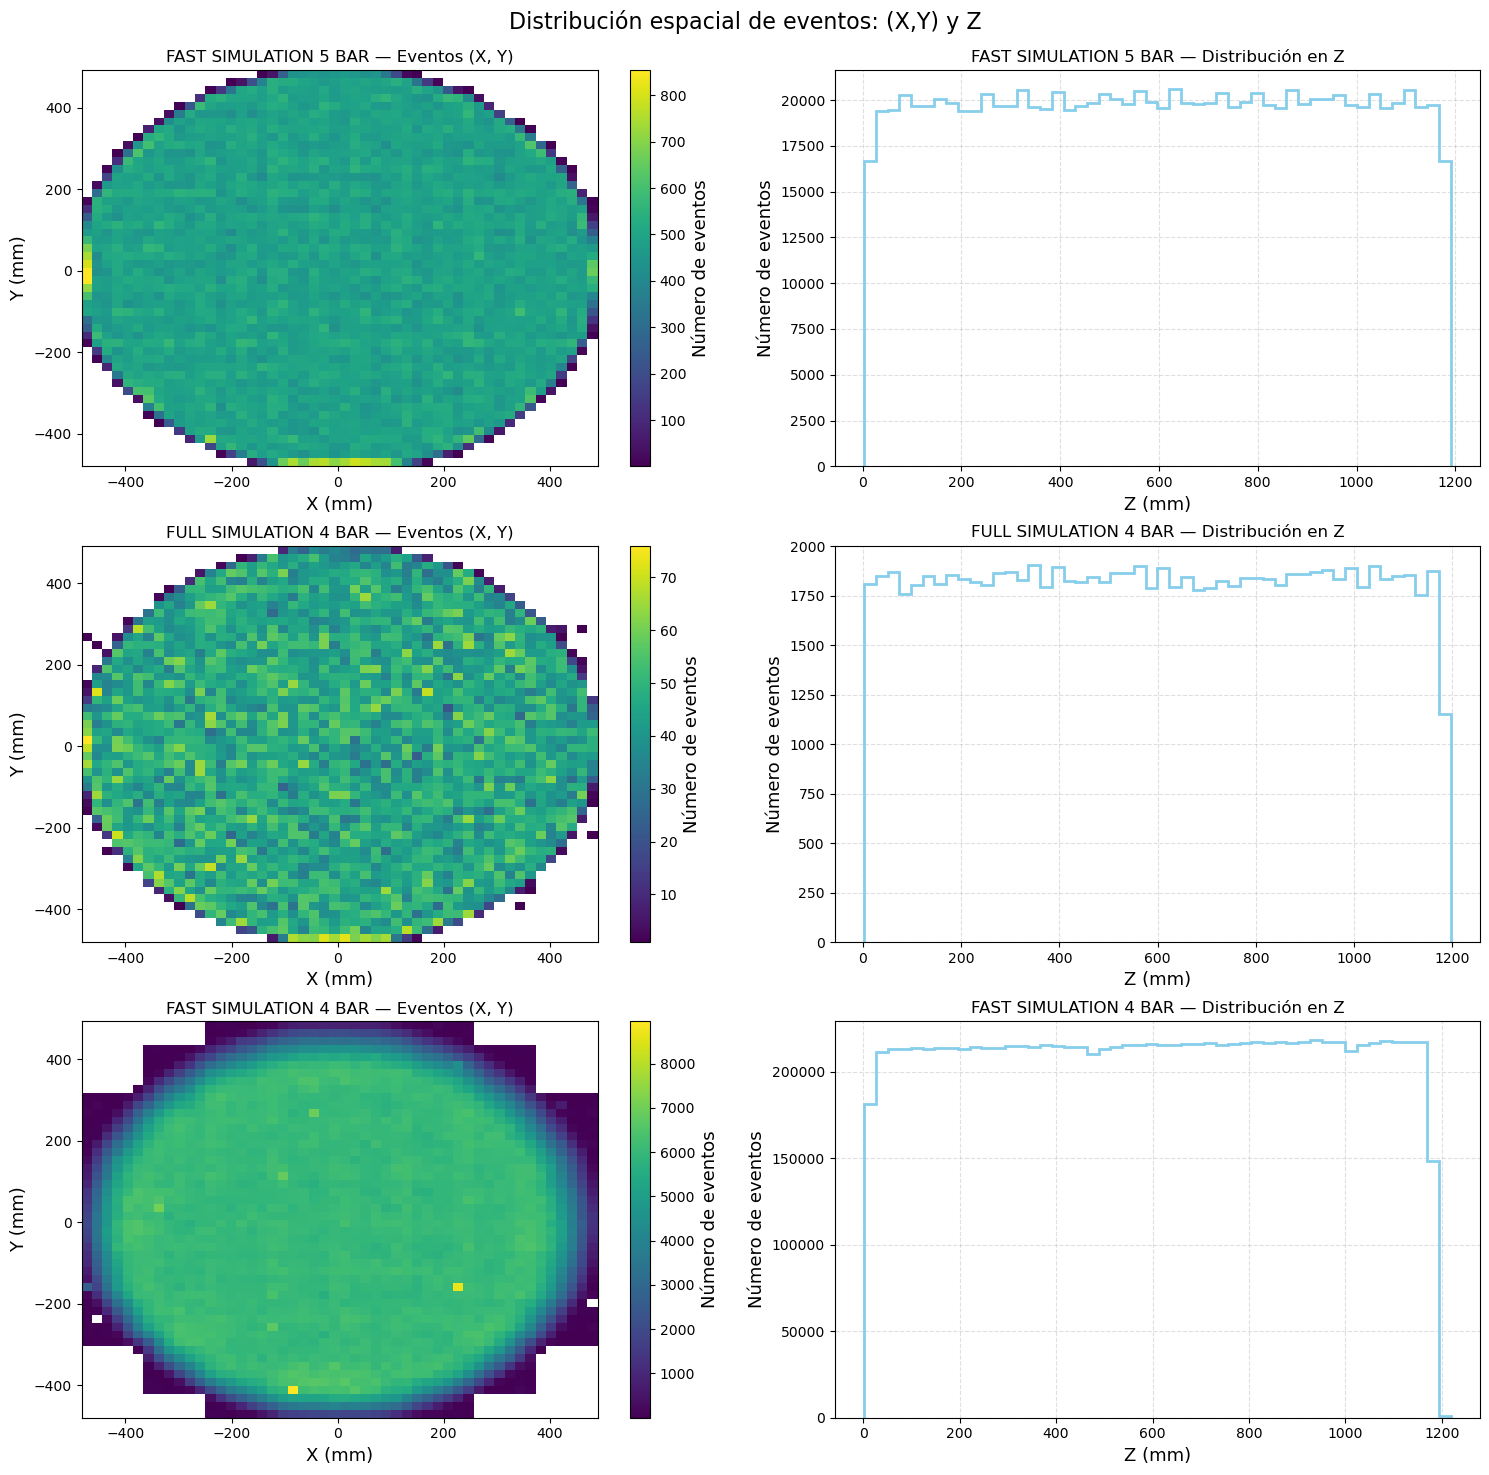

In [216]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
simulaciones=[sim1, sim2, sim3]
for i, (sim, titulo) in enumerate(zip(simulaciones, titulos)):
    ax_xy = ax[i, 0]
    ax_z = ax[i, 1]

    # Histograma de X frente a Y
    h = ax_xy.hist2d(sim['X'], sim['Y'], bins=50, cmap='viridis', cmin=1)
    ax_xy.set_title(f"{titulo} — Eventos (X, Y)")
    ax_xy.set_xlabel('X (mm)')
    ax_xy.set_ylabel('Y (mm)')
    fig.colorbar(h[3], ax=ax_xy, label='Número de eventos')

    # Histograma de Z
    ax_z.hist(sim['Z'], bins=50, histtype='step', edgecolor='skyblue', linewidth=2 )
    ax_z.set_title(f"{titulo} — Distribución en Z")
    ax_z.set_xlabel('Z (mm)')
    ax_z.set_ylabel('Número de eventos')
    ax_z.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
fig.suptitle('Distribución espacial de eventos: (X,Y) y Z', fontsize=16)
plt.subplots_adjust(top=0.94)
plt.savefig("graficas/densidad de eventos")

# S1e frente a Z

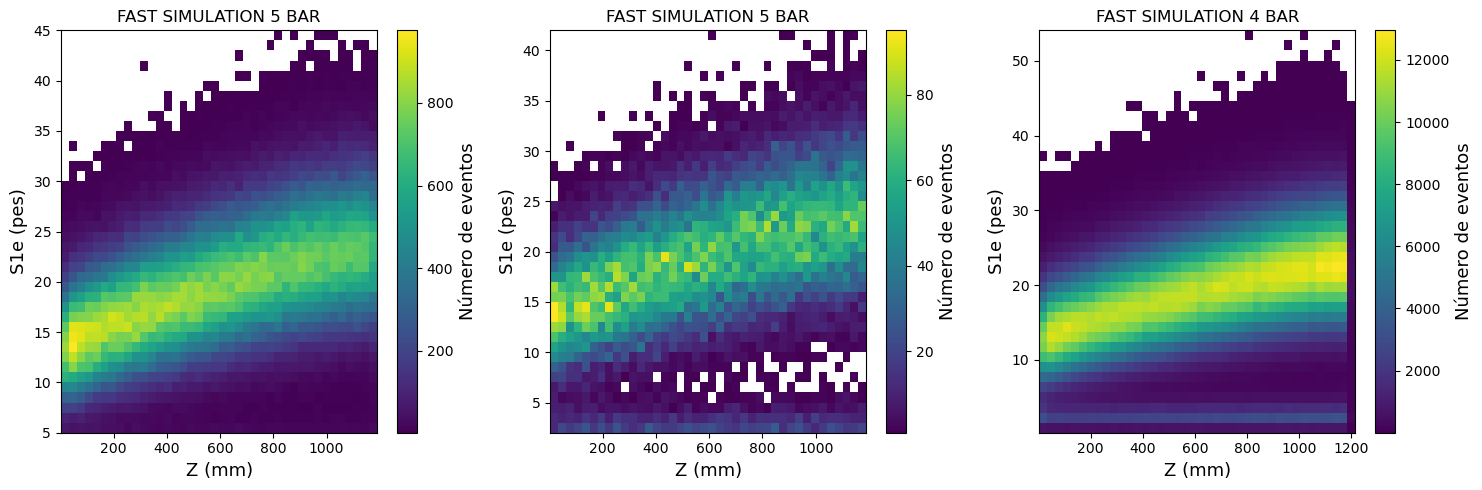

In [218]:
# Filtramos a R < 300 mm
sim1_300 = sim1[(sim1.R <= 300)]
sim2_300 = sim2[(sim2.R <= 300)]
sim3_300 = sim3[(sim3.R <= 300)]

sims = [sim1_300, sim2_300, sim3_300]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Simulación 1
h1 = axes[0].hist2d(sim1_300['Z'], sim1_300['S1e'], bins=[40, 40], cmin=1)
cbar1 = fig.colorbar(h1[3], ax=axes[0])  
axes[0].set_xlabel('Z (mm)')
axes[0].set_ylabel('S1e (pes)')
axes[0].set_title(titulos[0])
cbar1.set_label('Número de eventos')

# Simulación 2
h2 = axes[1].hist2d(sim2_300['Z'], sim2_300['S1e'], bins=[40, 40], cmin=1)
cbar2 = fig.colorbar(h2[3], ax=axes[1]) 
axes[1].set_xlabel('Z (mm)')
axes[1].set_ylabel('S1e (pes)')
axes[1].set_title(titulos[0])
cbar2.set_label('Número de eventos')


# Simulación 3
h3 = axes[2].hist2d(sim3_300['Z'], sim3_300['S1e'], bins=[40, 40], cmin=1)
cbar3 = fig.colorbar(h3[3], ax=axes[2])  
axes[2].set_xlabel('Z (mm)')
axes[2].set_ylabel('S1e (pes)')
axes[2].set_title(titulos[2])
cbar3.set_label('Número de eventos')

# fig.suptitle('S1e vs Z (R < 300 mm)', fontsize=16)
plt.tight_layout()
plt.savefig('graficas/S1e vs Z R300mm')

In [219]:
# Función para analizar el profile
def plot_profile(ax, x, y, bins=25, color='red', marker='*', label=None):
    
    # Crear bordes y centros de los bins
    bin_edges = np.linspace(x.min(), x.max(), bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Arrays de medias y errores
    mean = np.full_like(bin_centers, np.nan, dtype=float)
    std_err = np.full_like(bin_centers, np.nan, dtype=float)

    for i in range(len(bin_centers)):
        mask = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
        valores = y[mask]
        N = len(valores)
        if N > 0:
            mean[i] = np.mean(valores)
            std_err[i] = np.std(valores, ddof=1) / np.sqrt(N)

    ax.errorbar(bin_centers, mean, yerr=std_err, fmt='*', color=color, capsize=3, markersize=4)

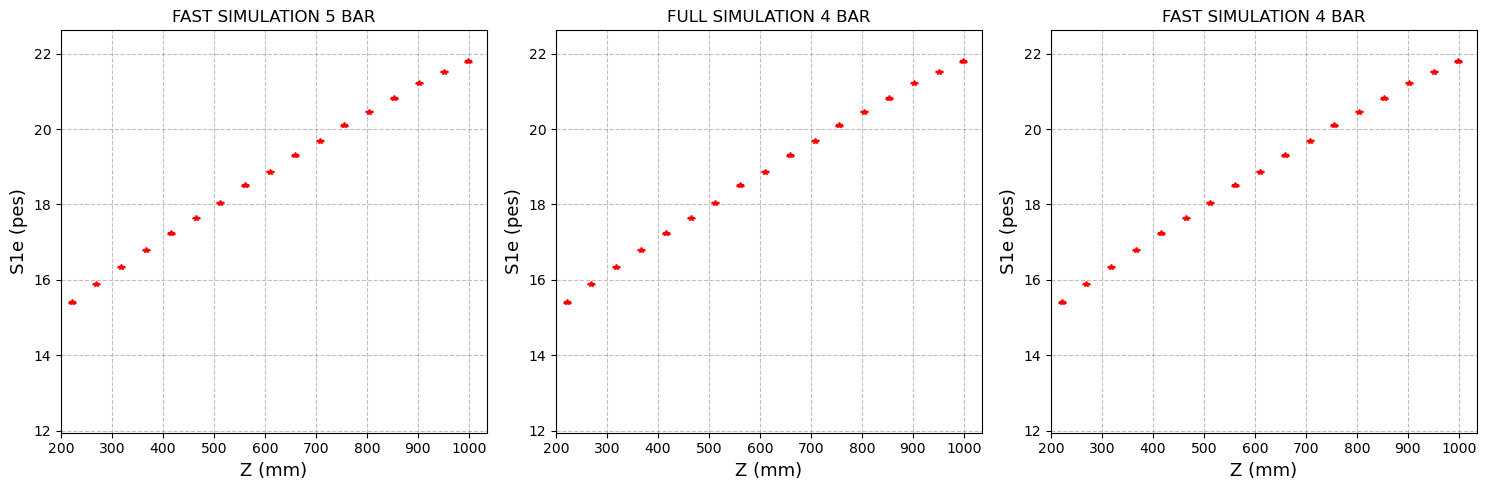

In [220]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for sims, ax, titulo in zip(sims, axes, titulos):
    plot_profile(ax, sim['Z'], sim['S1e'])
    ax.set_xlabel('Z (mm)')
    ax.set_ylabel('S1e (pes)')
    ax.set_title(titulo)
    ax.set_xlim(200, 1035)
    ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
# fig.savefig("graficas/profile S1e vs Z")

Cogemos R<300 mm

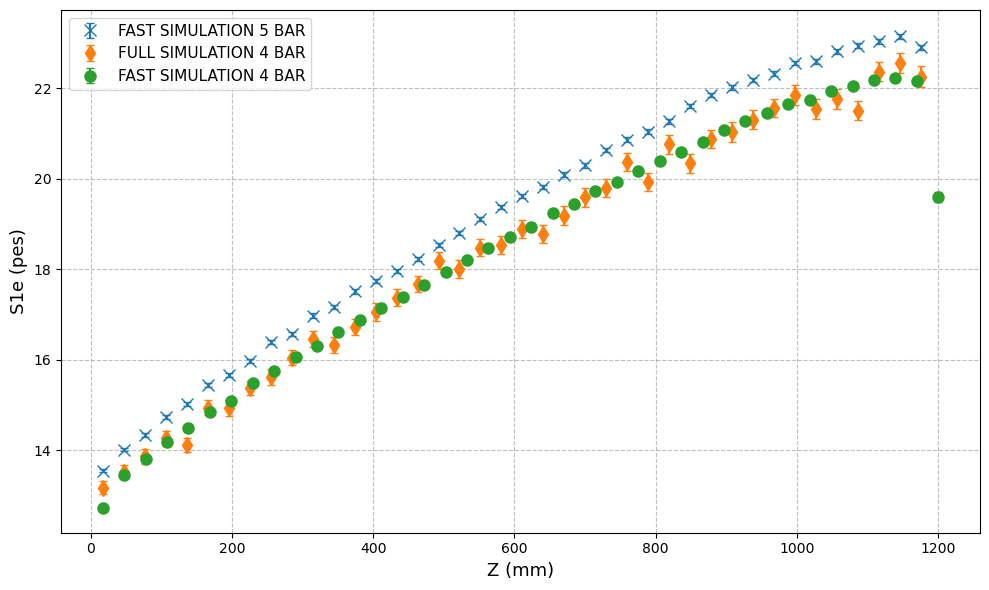

In [222]:
# Redefinimos el profile para ponerlo en la misma gráfica con distintos colores y marcadores
def plot_profile(ax, x, y, bins, color='red', marker='*', label=None):
    # Crear bordes y centros de los bins
    bin_edges = np.linspace(x.min(), x.max(), bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Arrays de medias y errores
    mean = np.full_like(bin_centers, np.nan, dtype=float)
    std_err = np.full_like(bin_centers, np.nan, dtype=float)

    for i in range(len(bin_centers)):
        mask = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
        valores = y[mask]
        N = len(valores)
        if N > 0:
            mean[i] = np.mean(valores)
            std_err[i] = np.std(valores, ddof=1) / np.sqrt(N)

    # Plot con barras de error
    ax.errorbar(
        bin_centers, mean, 
        yerr=std_err, 
        fmt=marker, 
        color=color, 
        capsize=3, 
        markersize=8, 
        label=label
    )

n_bins  = 40
markers = ['x', 'd', 'o']
labels  = titulos
colors  = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(figsize=(10, 6))
sim_list = [sim1_300, sim2_300, sim3_300]

# Dibujar cada simulación usando plot_profile
for sim, m, lab, col in zip(sim_list, markers, labels, colors):
    plot_profile(ax, x=sim['Z'], y=sim['S1e'], bins=n_bins, color=col, marker=m, label=lab )

ax.set_xlabel("Z (mm)")
ax.set_ylabel("S1e (pes)")
ax.grid(True, which="both", linestyle="--", color="gray", alpha=0.5)
ax.legend(loc="best", fontsize=11)
plt.tight_layout()


Se observa que en en la tercera simulación, Fast Simulation 4 bars la componente "Z" es ligeramente mayoir que en las otras imulaciones, además que dicho intervalo tiene muy pocos eventos por lo que procedemos eliminarlo del "profile".

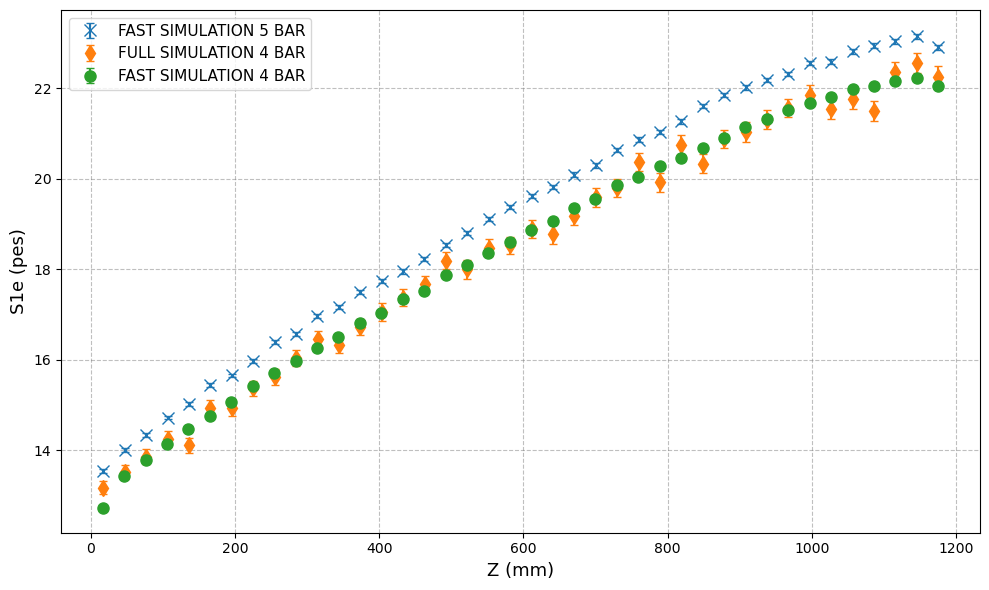

In [224]:
Zmax = sim2_300["Z"].max()
sim3_300.loc[:, "Z"] = np.minimum(sim3_300["Z"], Zmax)

fig, ax = plt.subplots(figsize=(10, 6))

for sim, m, lab, col in zip(sim_list, markers, labels, colors):
    plot_profile(ax, x=sim['Z'], y=sim['S1e'], bins=n_bins, color=col, marker=m, label=lab )

ax.set_xlabel("Z (mm)")
ax.set_ylabel("S1e (pes)")
ax.grid(True, which="both", linestyle="--", color="gray", alpha=0.5)
ax.legend(loc="best", fontsize=11)
plt.tight_layout()
fig.savefig("graficas/profile S1e vs Z")

# S2e frente a DT

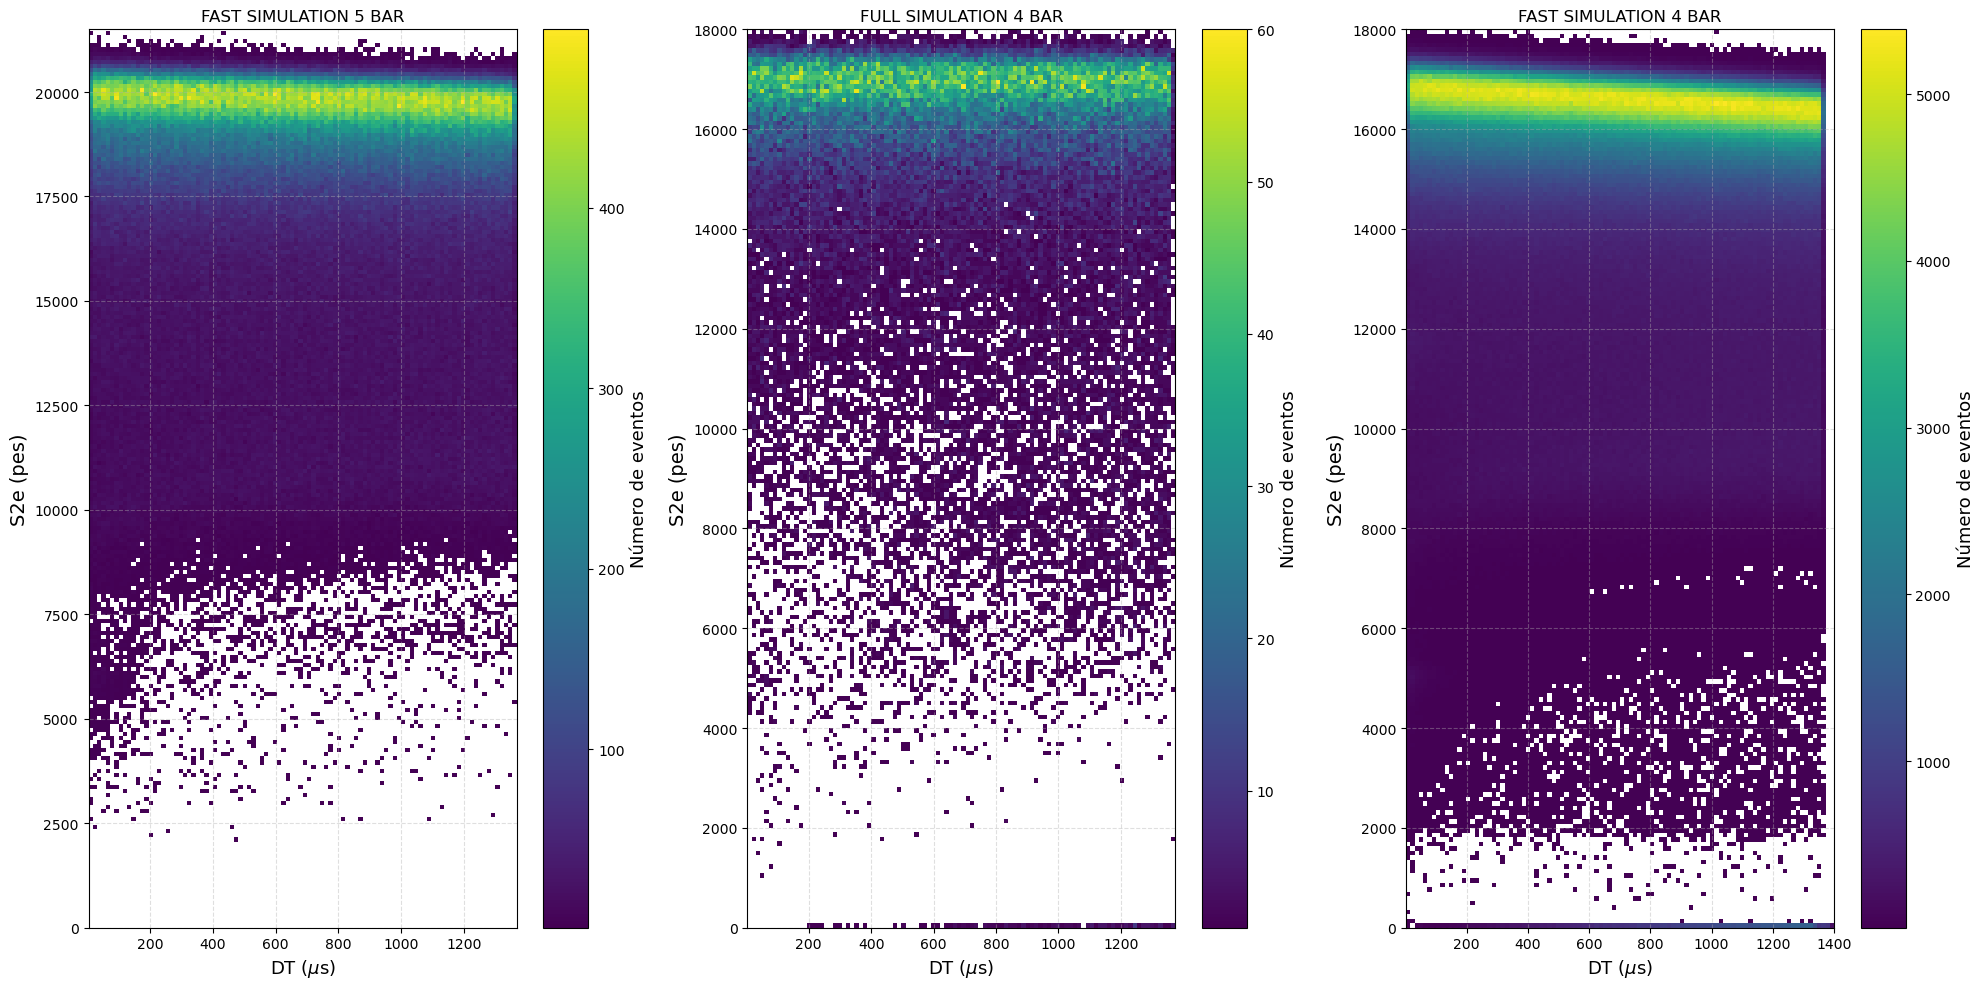

In [226]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Datos y configuraciones
datos = [
    (sim1['DT'], sim1['S2e'], (0, 21500)),
    (sim2['DT'], sim2['S2e'], (0, 18000)),
    (sim3['DT'], sim3['S2e'], (0, 18000))]

# Graficar en bucle
for i, ax in enumerate(axes):
    DT, S2e, ylim = datos[i]
    h = ax.hist2d(DT, S2e, bins=[100, 200], cmin=1)
    ax.set_xlabel('DT ($\\mu$s)')
    ax.set_ylabel('S2e (pes)', fontsize=14)
    ax.set_title(titulos[i])
    ax.set_ylim(*ylim)

    # Duplicar ticks y etiquetas del eje Y a la derecha
    # ax.yaxis.set_ticks_position('both')
    # ax.tick_params(axis='y', labelright=True)

    # Colorbar asociado
    cbar = plt.colorbar(h[3], ax=ax)
    cbar.set_label('Número de eventos')
    ax.grid(True, linestyle='--', alpha=0.4)

# Título general y diseño
plt.tight_layout()
plt.savefig("graficas/S2e")

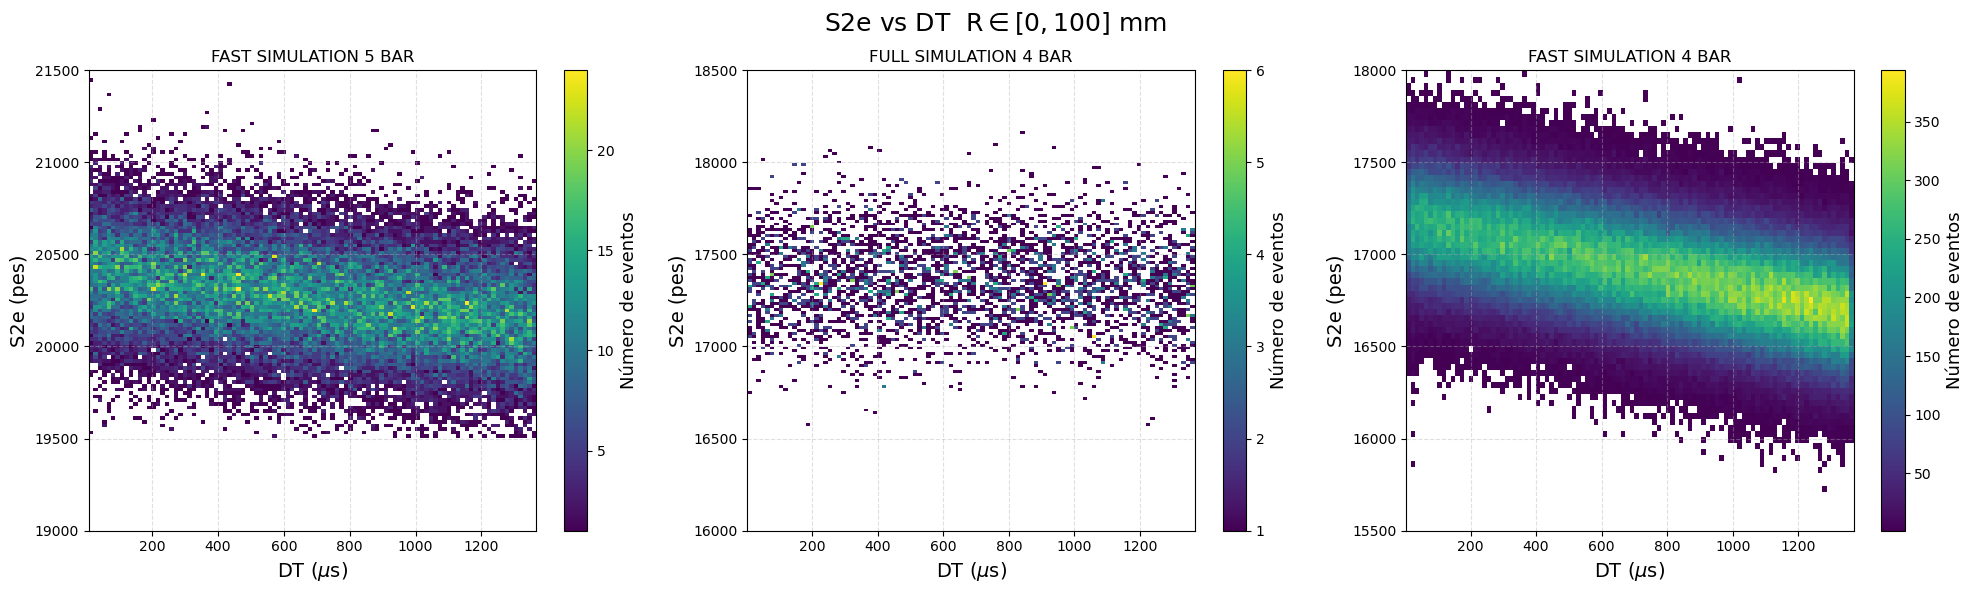

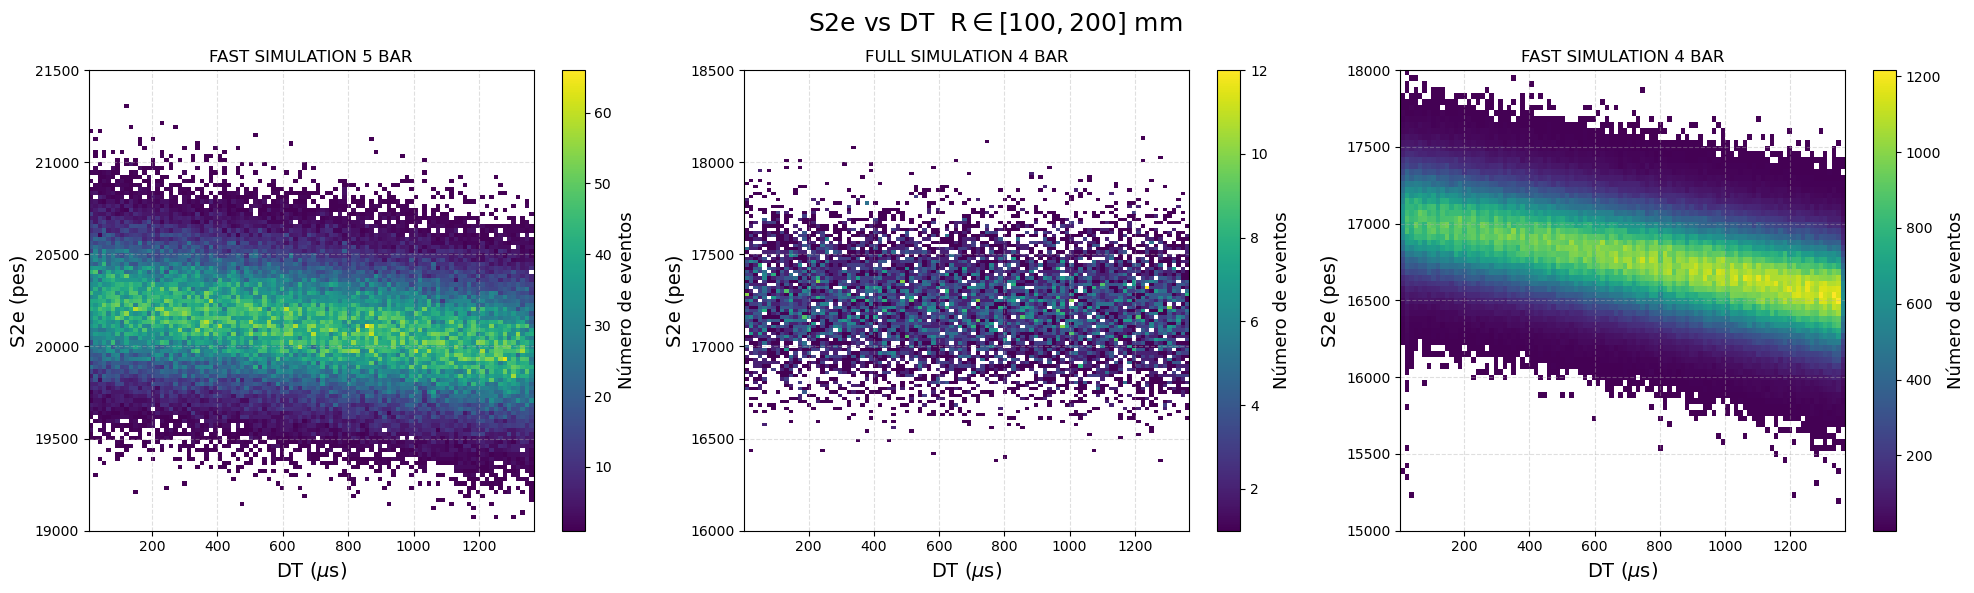

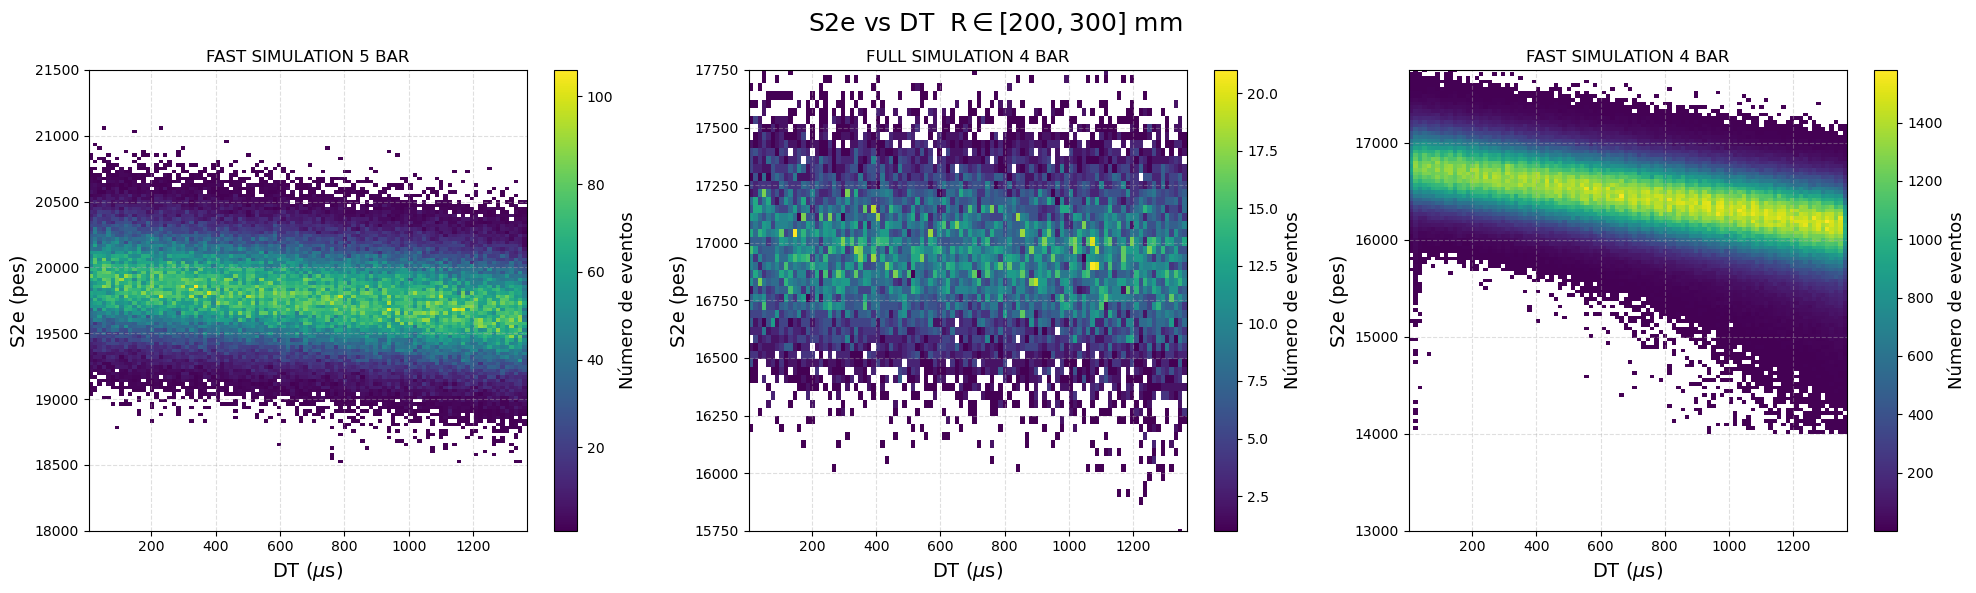

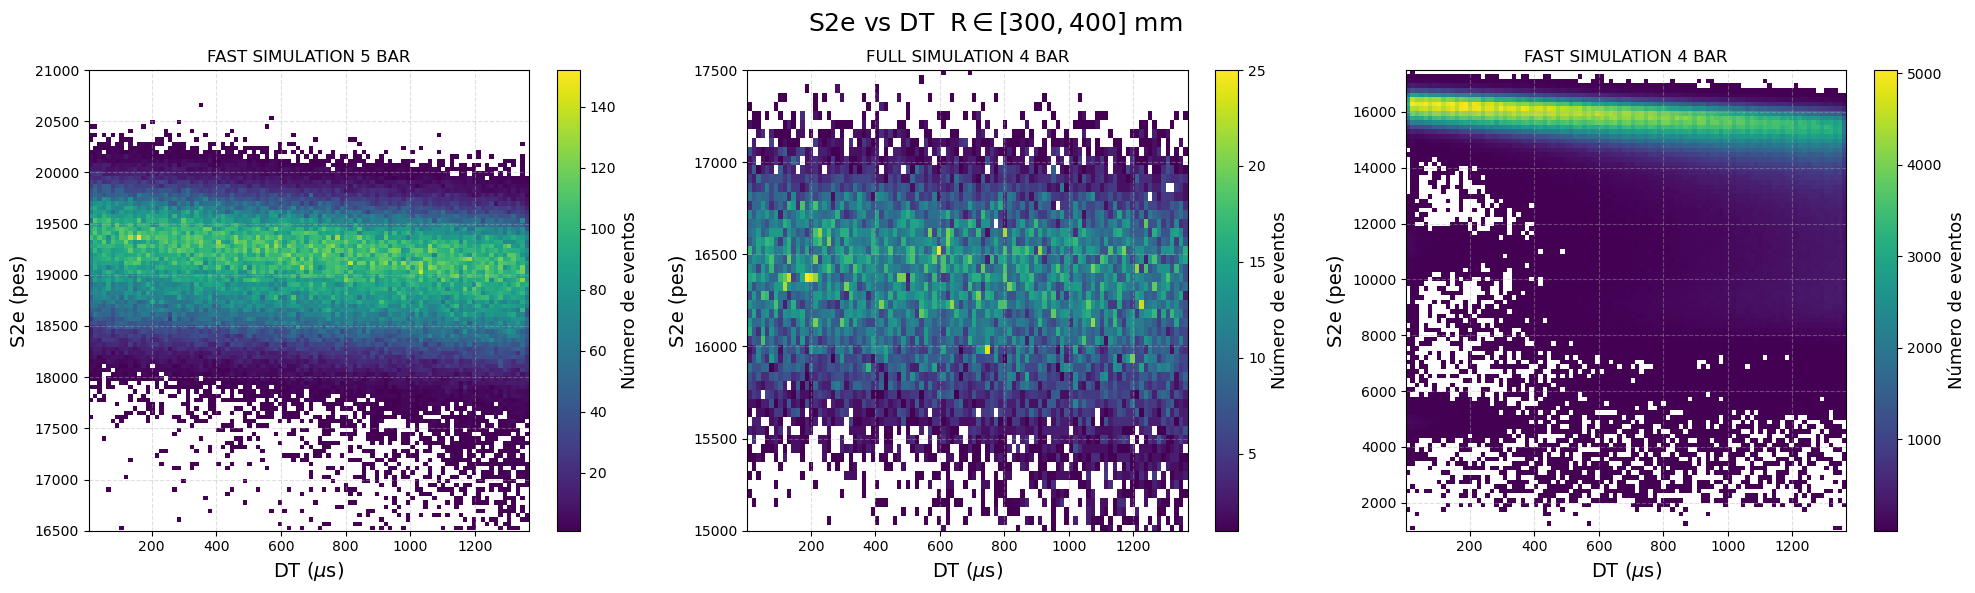

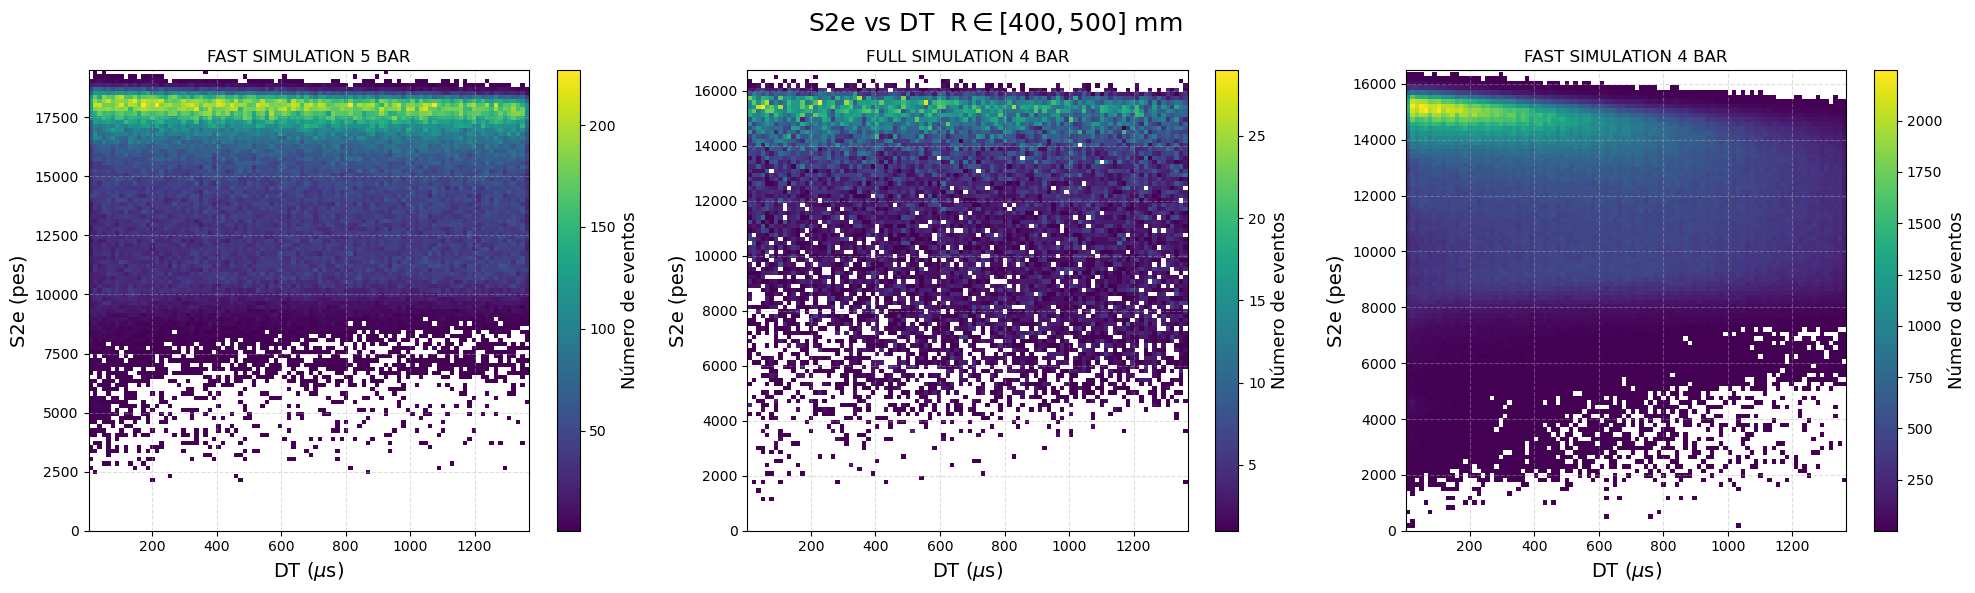

In [227]:
# --- Anillos radiales ---
anillos = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500)]
simulaciones = [sim1, sim2, sim3]

# --- Nuevos límites de Y (visualmente ajustados) ---
ylims = {
    (0, 100):   [(19000, 21500), (16000, 18500), (15500, 18000)],
    (100, 200): [(19000, 21500), (16000, 18500), (15000, 18000)],
    (200, 300): [(18000, 21500), (15750, 17750), (13000, 17750)],
    (300, 400): [(16500, 21000), (15000, 17500), (1000, 17500)],
    (400, 500): [(0, 19500), (0, 16750), (0, 16500)],
}

# --- Nuevos cortes de S2e por bin ---
cortes_s2e = {
    (0, 100):   [19500, 14700, 14700],
    (100, 200): [19000, 14400, 14000],
    (200, 300): [18500, 13700, 14000],
    (300, 400): [16500, 12600, 1000],
    (400, 500): [100, 100, 100],
}

# --- Graficar por anillo ---
for r_min, r_max in anillos:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for i, ax in enumerate(axes):
        sim = simulaciones[i]
        s2e_min = cortes_s2e[(r_min, r_max)][i]
        ylim = ylims[(r_min, r_max)][i]

        df = sim[(sim.R > r_min) & (sim.R <= r_max) & (sim.S2e > s2e_min)]
        DT = df['DT']
        S2e = df['S2e']

        h = ax.hist2d(DT, S2e, bins=[100, 100], cmin=1)
        ax.set_xlabel('DT ($\\mu$s)', fontsize=14)
        ax.set_ylabel('S2e (pes)', fontsize=14)
        ax.set_title(titulos[i])
        ax.set_ylim(*ylim)
        ax.grid(True, linestyle='--', alpha=0.4)

        # ax.yaxis.set_ticks_position('both')
        # ax.tick_params(axis='y', labelright=True)

        cbar = plt.colorbar(h[3], ax=ax)
        cbar.set_label('Número de eventos')

    fig.suptitle(f"S2e vs DT  R$\\in [{r_min}, {r_max}]$ mm", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

**No me queda claro dónde cortar los para los últimos radios**

In [229]:
# Guardamos graficas individualmente por anillo
out_dir = "graficas/anillos"
os.makedirs(out_dir, exist_ok=True)

# --- Graficar y guardar por anillo ---
for r_min, r_max in anillos:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for i, ax in enumerate(axes):
        sim = simulaciones[i]
        s2e_min = cortes_s2e[(r_min, r_max)][i]
        ylim = ylims[(r_min, r_max)][i]

        df = sim[(sim.R > r_min) & (sim.R <= r_max) & (sim.S2e > s2e_min)]
        DT = df['DT']
        S2e = df['S2e']

        h = ax.hist2d(DT, S2e, bins=[100, 100], cmin=1)
        ax.set_xlabel('DT ($\\mu$s)', fontsize=14)
        ax.set_ylabel('S2e (pes)', fontsize=14)
        ax.set_title(titulos[i])
        ax.set_ylim(*ylim)

        # ax.yaxis.set_ticks_position('both') # para poner el eje y tmb en el lado derecho
        # ax.tick_params(axis='y', labelright=True)

        cbar = plt.colorbar(h[3], ax=ax)
        cbar.set_label('Número de eventos')

    fig.suptitle(f"S2e vs Z  DT$\\in [{r_min}, {r_max}]$ mm", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Guardar la figura por anillo
    fname = f"S2e_vs_DT_R_{r_min:03d}-{r_max:03d}_mm.png"
    fig.savefig(os.path.join(out_dir, fname), dpi=300)
    plt.close(fig)

## Correción de S2e por la lifetime


FAST SIMULATION 5 BAR:
  R ∈ (0,100] mm → τ = 104870.7 ± 3759.5 μs
  R ∈ (100,200] mm → τ = 102674.1 ± 2048.6 μs
  R ∈ (200,300] mm → τ = 103277.0 ± 1762.3 μs
  R ∈ (300,400] mm → τ = 75395.7 ± 1065.9 μs
  R ∈ (400,500] mm → τ = 42157.5 ± 1552.7 μs

FULL SIMULATION 4 BAR:
  R ∈ (0,100] mm → τ = 702982.4 ± 742977.6 μs
  R ∈ (100,200] mm → τ = 221035.2 ± 73901.6 μs
  R ∈ (200,300] mm → τ = 162779.4 ± 27740.6 μs
  R ∈ (300,400] mm → τ = 39285.4 ± 1899.8 μs
  R ∈ (400,500] mm → τ = 14395.0 ± 792.7 μs

FAST SIMULATION 4 BAR:
  R ∈ (0,100] mm → τ = 33210.5 ± 342.8 μs
  R ∈ (100,200] mm → τ = 30252.0 ± 176.7 μs
  R ∈ (200,300] mm → τ = 21944.3 ± 77.2 μs
  R ∈ (300,400] mm → τ = 7431.1 ± 9.8 μs
  R ∈ (400,500] mm → τ = 6274.9 ± 16.3 μs


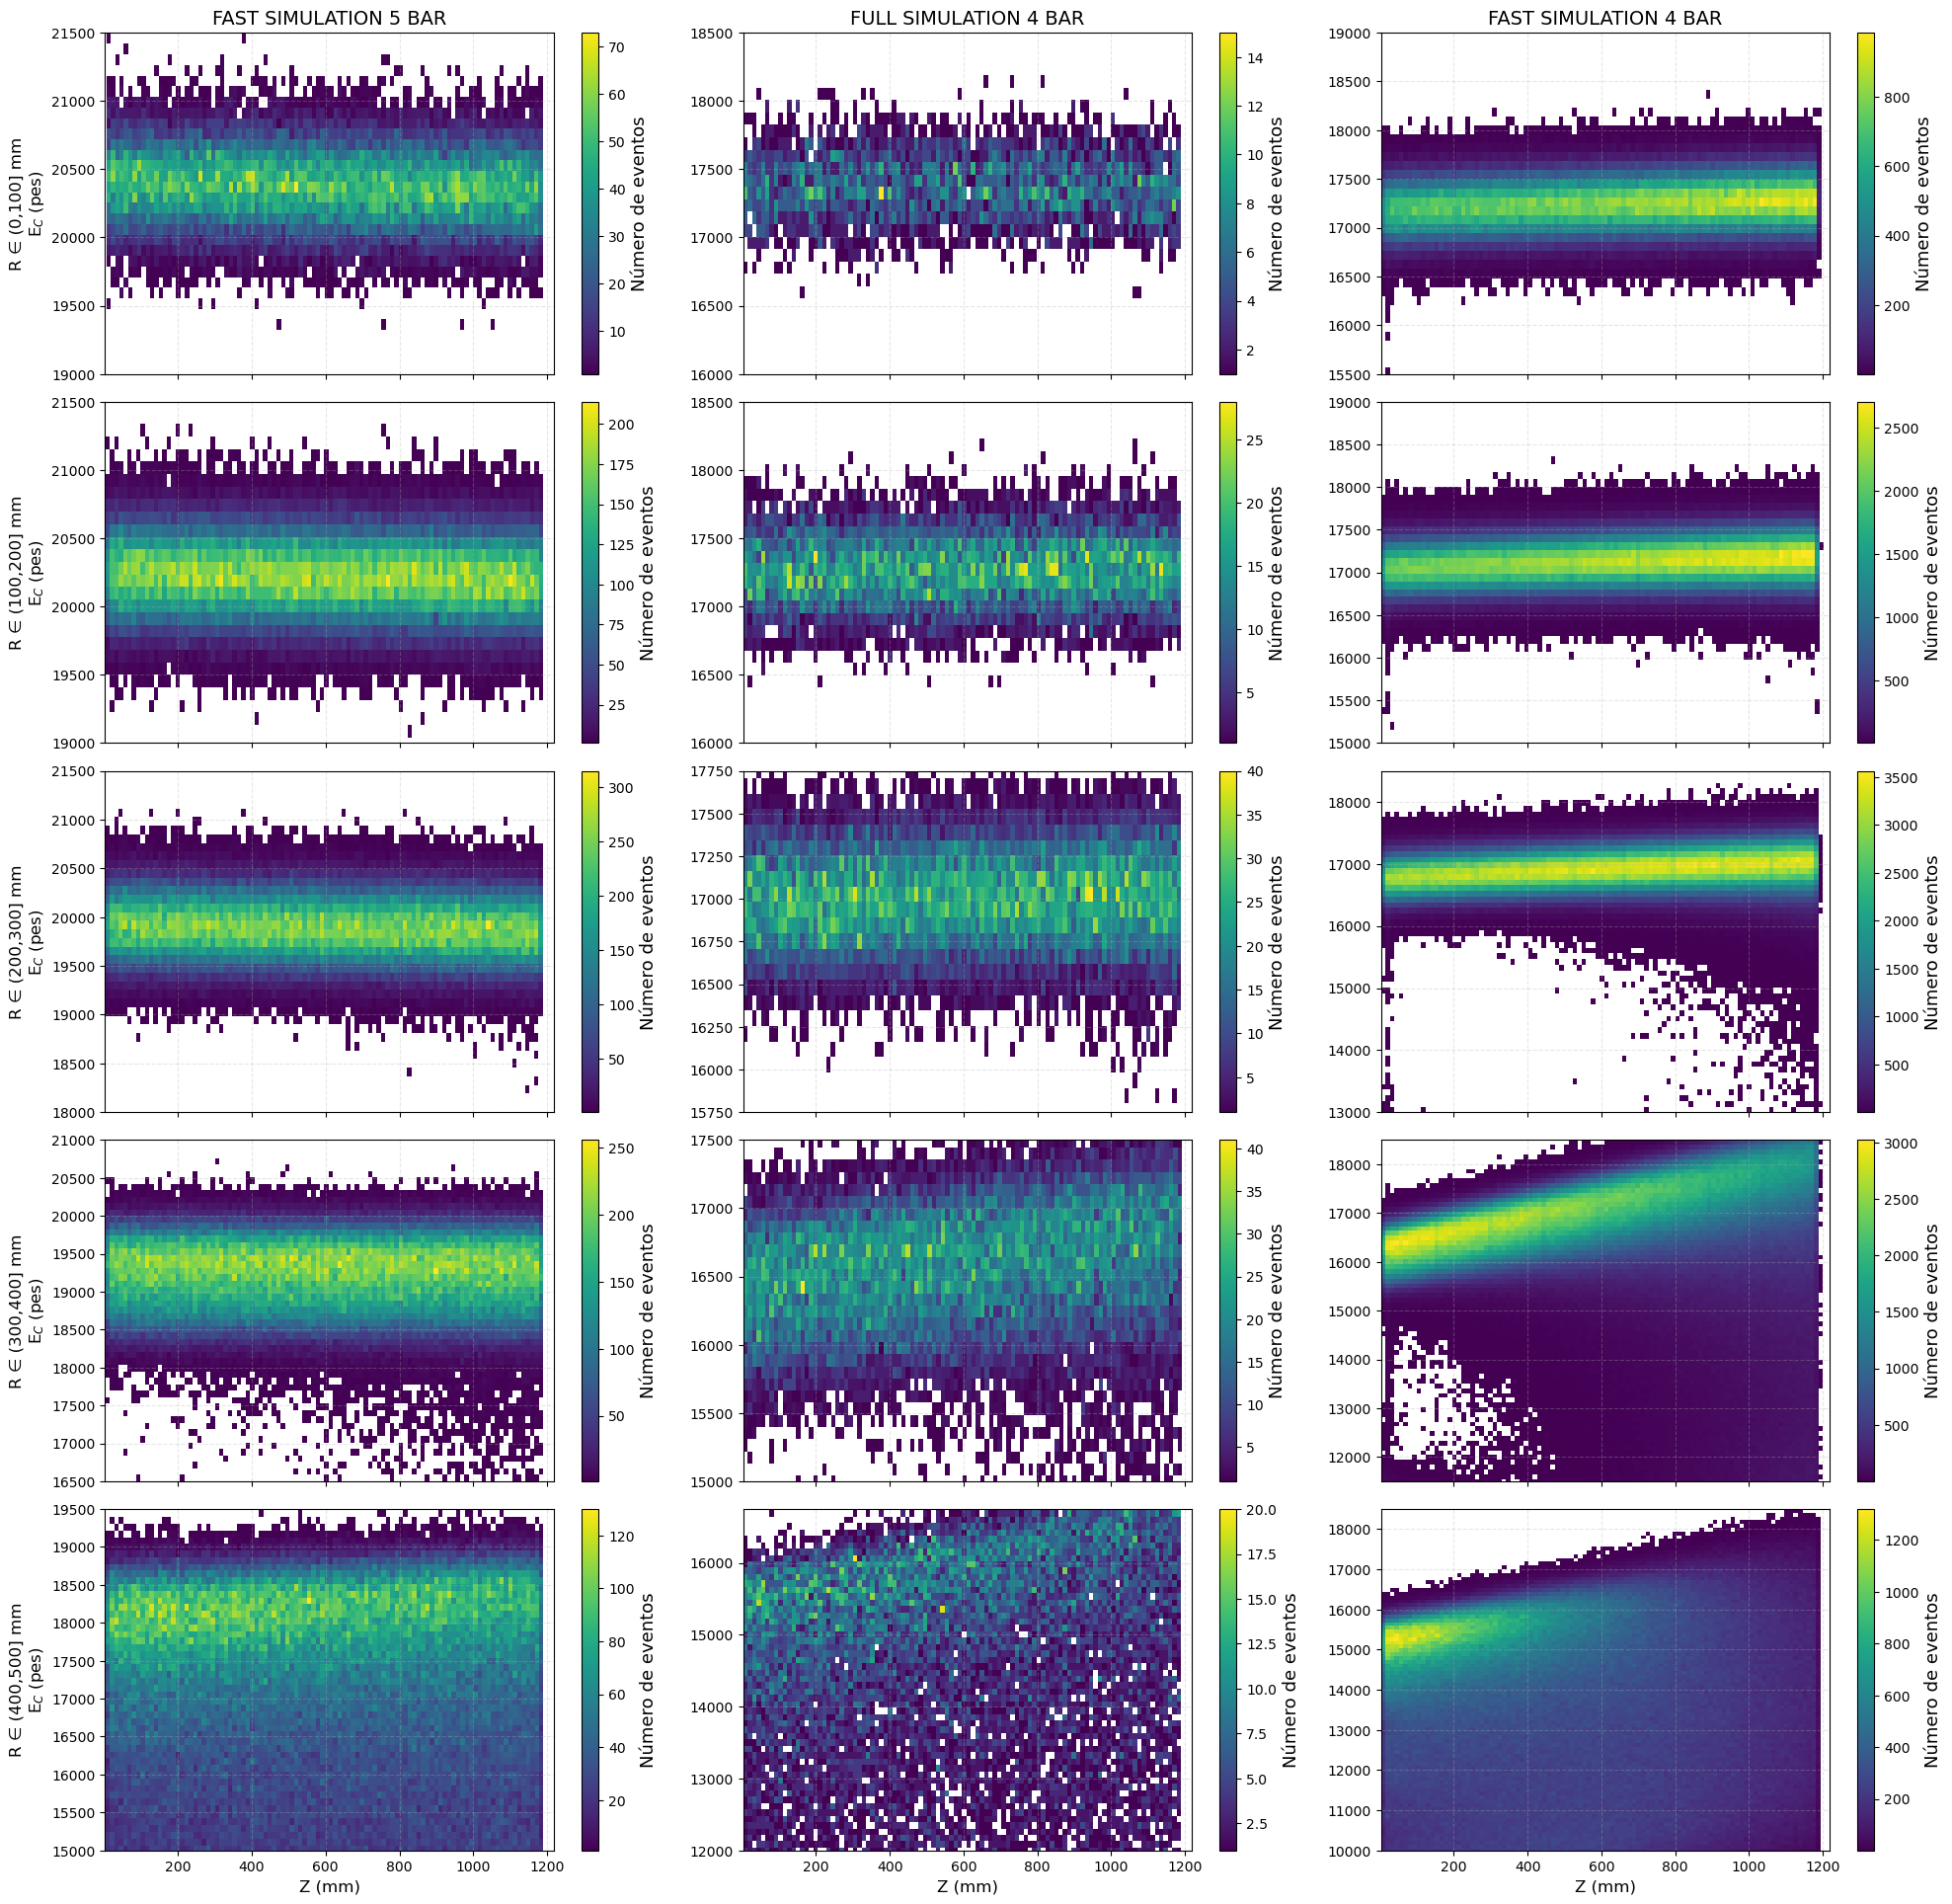

In [231]:
# --- Modelo exponencial ---
def modelo_exp(DT, E0, tau):
    return E0 * np.exp(-DT / tau)

# --- Límites Y personalizados ---
ylims = {
    (0, 100):   [(19000, 21500), (16000, 18500), (15500, 19000)],
    (100, 200): [(19000, 21500), (16000, 18500), (15000, 19000)],
    (200, 300): [(18000, 21500), (15750, 17750), (13000, 18500)],
    (300, 400): [(16500, 21000), (15000, 17500), (11500, 18500)],
    (400, 500): [(15000, 19500), (12000, 16750), (10000, 18500)],
}

# --- Preparar arrays para taus y sus errores ---
n_sims   = len(simulaciones)
n_anillos = len(anillos)
taus      = np.zeros((n_sims, n_anillos))
tau_errs  = np.zeros((n_sims, n_anillos))

# Creamos una variable vacía para poder gaurdar la E_C y después ver su desviación 
Ec_all = [[None for _ in range(n_anillos)] for _ in range(n_sims)]

# --- Creamos figura grande con un subplot por (anillo, simulación) ---
fig, axs = plt.subplots(n_anillos, n_sims, figsize=(20, 4 * n_anillos), sharex=True)

for i_sim, (sim, titulo) in enumerate(zip(simulaciones, titulos)):
    for j_anillo, (r_min, r_max) in enumerate(anillos):
        # Filtrar datos del anillo radial
        df  = sim[(sim["R"] > r_min) & (sim["R"] <= r_max)]
        Z   = df["Z"].values
        S2e = df["S2e"].values

        # Ajuste exponencial y cálculo de incertidumbre
        try:
            popt, pcov = curve_fit(modelo_exp, Z, S2e, p0=[np.max(S2e), 1000])
            E0, tau = popt
            tau_err = np.sqrt(np.diag(pcov))[1]
        except (RuntimeError, ValueError):
            tau, tau_err = np.nan, np.nan

        taus[i_sim, j_anillo]     = tau
        tau_errs[i_sim, j_anillo] = tau_err

        # Corrección de S2e
        Ec = S2e * np.exp(Z / tau) if not np.isnan(tau) else S2e
        Ec_all[i_sim][j_anillo] = Ec

        # Histograma 2D: Z vs E_C
        ax = axs[j_anillo, i_sim]
        h  = ax.hist2d(Z, Ec, bins=[100, 200], cmin=1, cmap='viridis')

        # Título y etiquetas
        if j_anillo == 0:
            ax.set_title(titulo, fontsize=14)
        if i_sim == 0:
            ax.set_ylabel(f"R ∈ ({r_min},{r_max}] mm\nE$_C$ (pes)", fontsize=12)
        if j_anillo == n_anillos - 1:
            ax.set_xlabel("Z (mm)", fontsize=12)

        # Aplicar límites Y
        ylim_actual = ylims[(r_min, r_max)][i_sim]
        ax.set_ylim(*ylim_actual)

        # Mostrar ticks Y a ambos lados
        # ax.yaxis.set_ticks_position('both')
        # ax.tick_params(axis='y', labelright=True)

        # Grid y colorbar
        ax.grid(True, linestyle='--', alpha=0.3)
        cbar = plt.colorbar(h[3], ax=ax)
        cbar.set_label('Número de eventos')

# Ajustes de la figura
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Imprimir taus con sus errores en consola
for i, titulo in enumerate(titulos):
    print(f"\n{titulo}:")
    for j, (r_min, r_max) in enumerate(anillos):
        t   = taus[i, j]
        dt  = tau_errs[i, j]
        print(f"  R ∈ ({r_min},{r_max}] mm → τ = {t:.1f} ± {dt:.1f} μs")

In [232]:
ylims = {
    (0, 100):   [(19000, 21500), (16000, 18500), (15500, 19000)],
    (100, 200): [(19000, 21500), (16000, 18500), (15000, 19000)],
    (200, 300): [(18000, 21500), (15750, 17750), (13000, 18500)],
    (300, 400): [(16500, 21000), (15000, 17500), (11500, 18500)],
    (400, 500): [(15000, 19500), (12000, 16750), (10000, 18500)],}

# Carpeta de salida 
out_dir = "graficas/anillos_exp"
os.makedirs(out_dir, exist_ok=True)

# Matriz almacena taus
taus = np.zeros((3, len(anillos)))
Ec_all = [[None for _ in range(n_anillos)] for _ in range(n_sims)]

# Loop por anillo
for j_anillo, (r_min, r_max) in enumerate(anillos):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
    
    for i_sim, (sim, titulo) in enumerate(zip(simulaciones, titulos)):
        # Filtrar datos del anillo
        df = sim[(sim["R"] > r_min) & (sim["R"] <= r_max)]
        Z = df["Z"].values
        S2e = df["S2e"].values

        # Ajuste exponencial
        try:
            popt, _ = curve_fit(modelo_exp, Z, S2e, p0=[np.max(S2e), 1000])
            E0, tau = popt
        except RuntimeError:
            E0, tau = np.nan, np.nan
        taus[i_sim, j_anillo] = tau

        # Corrección de S2e
        Ec = S2e * np.exp(Z / tau)
        Ec_all[i_sim][j_anillo] = Ec

        # Histograma 2D: Z vs E_C
        ax = axes[i_sim]
        h = ax.hist2d(Z, Ec, bins=[100, 200], cmin=1, cmap='viridis')

        # Etiquetas y título
        ax.set_title(titulo, fontsize=15)
        ax.set_xlabel("Z (mm)", fontsize=13)

        # Límites Y
        ylim_actual = ylims[(r_min, r_max)][i_sim]
        ax.set_ylim(*ylim_actual)

        # Colorbar
        cbar = plt.colorbar(h[3], ax=ax)
        cbar.set_label('Número de eventos')
        ax.grid(True, linestyle='--', alpha=0.4)

    # Título general y ajustes
    fig.suptitle(f"R ∈ [{r_min}, {r_max}] mm", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Guardar figura
    fname = f"Ec_vs_Z_R_{r_min:03d}-{r_max:03d}_mm.png"
    fig.savefig(os.path.join(out_dir, fname), dpi=300)
    plt.close(fig)

## Desviación de la correción

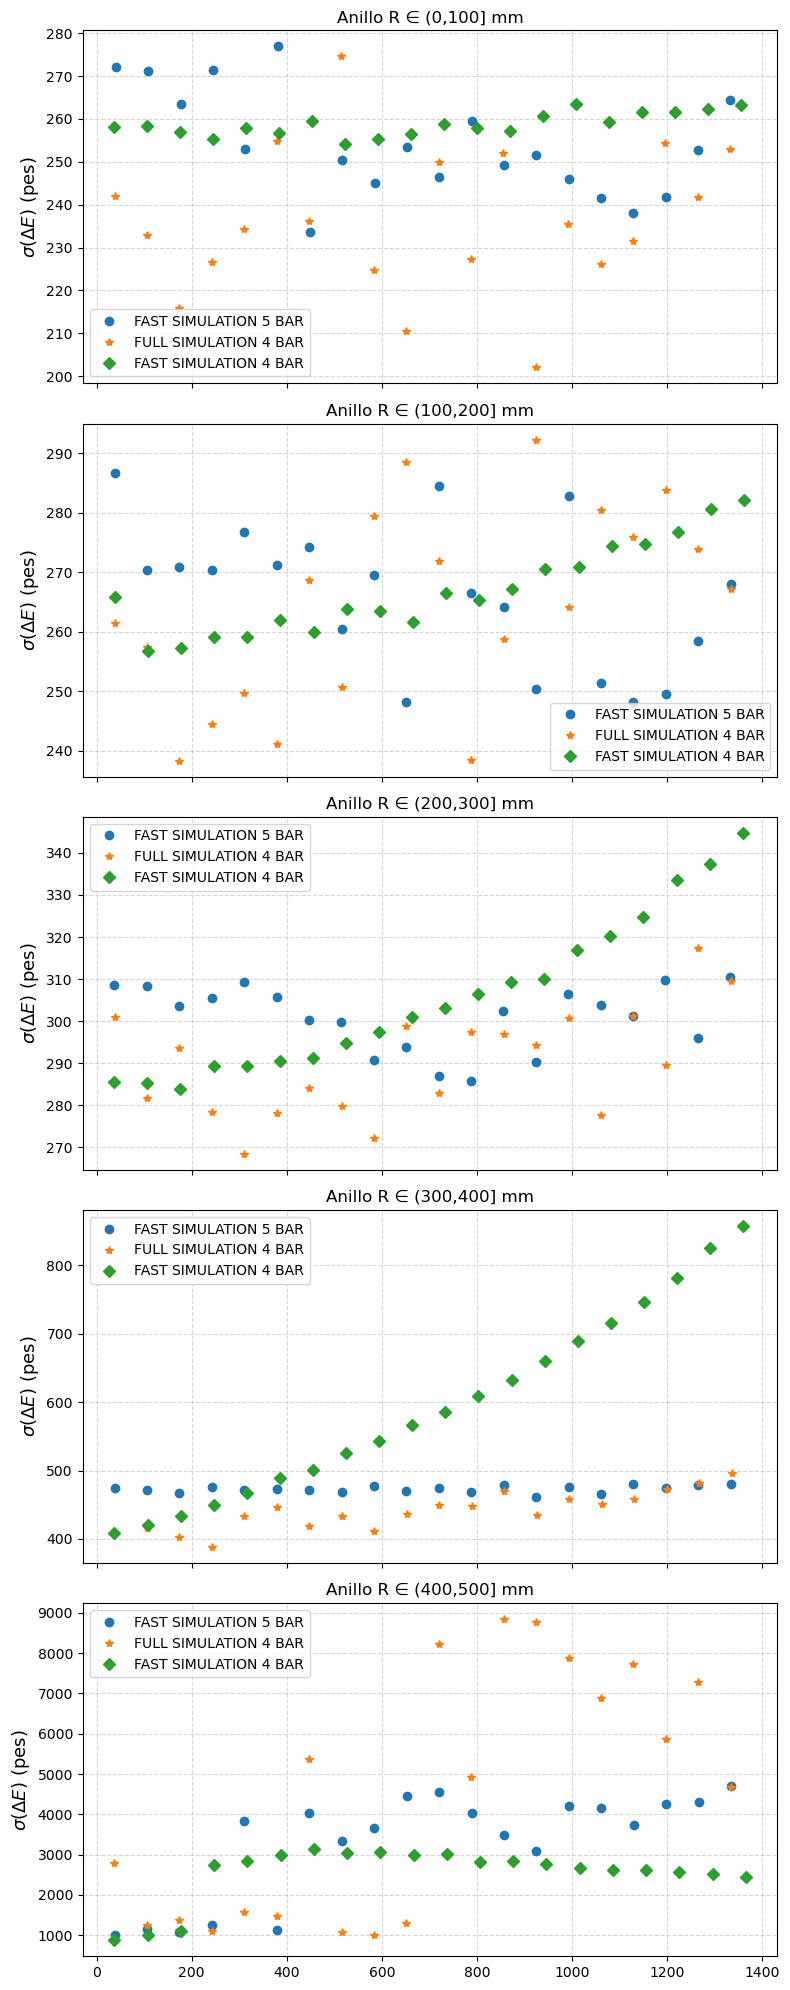

In [234]:
# Gaussiana ---
def gaussiana(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

# --- Simulaciones de perfil con DT ---
simulaciones = [sim1, sim2, sim3]
marcadores          = ['o', '*', 'D']  # círculo, asterisco y diamante

# --- Anillos radiales y Ec_all definidos previamente ---
anillos = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500)]
# Ec_all[i_sim][j_anillo] contiene array de E_c para la i-ésima sim, j-ésimo anillo

n_anillos = len(anillos)

# --- Figura con un subplot por anillo ---
fig, axs = plt.subplots(n_anillos, 1, figsize=(8, 4*n_anillos), sharex=True)

for j_anillo, (r_min, r_max) in enumerate(anillos):
    ax = axs[j_anillo]
    for i_sim, (sim, titulo, marcador) in enumerate(zip(simulaciones, titulos, marcadores)):
        # Filtrar por anillo radial en la simulación de perfil
        mask = (sim['R'] > r_min) & (sim['R'] <= r_max)
        DT = sim.loc[mask, 'DT'].values
        E_c = Ec_all[i_sim][j_anillo]
       
        # Si no coinciden tamaños, aplicar misma máscara a E_c
        if len(E_c) != len(DT):
            # Asumimos que E_c está en el mismo orden que sim_profile, filtramos
            E_c = E_c[mask.values]

        # Bins y centros de DT
        bins       = np.linspace(DT.min(), DT.max(), 21)
        dt_centers = 0.5 * (bins[:-1] + bins[1:])

        sigmas = []
        for k in range(len(bins)-1):
            bin_mask = (DT >= bins[k]) & (DT < bins[k+1])
            delta_E  = E_c[bin_mask] - np.mean(E_c[bin_mask]) if np.sum(bin_mask) >= 10 else np.array([])
            if len(delta_E) < 10:
                sigmas.append(np.nan)
                continue

            counts, edges = np.histogram(delta_E, bins=40)
            centers       = 0.5 * (edges[:-1] + edges[1:])
            try:
                p0     = [counts.max(), 0, np.std(delta_E)]
                popt   = curve_fit(gaussiana, centers, counts, p0=p0)[0]
                sigma  = popt[2]
            except RuntimeError:
                sigma = np.nan
            sigmas.append(sigma)

        # Plot
        ax.plot(dt_centers, sigmas, marker=marcador, linestyle='None', label=titulo)

    ax.set_ylabel(r'$\sigma(\Delta E)$ (pes)')
    ax.set_title(f'Anillo R ∈ ({r_min},{r_max}] mm')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    plt.tight_layout()

#     # # Guardar figura en archivo separado según radio
#     # filename = f"graficas/sigma_DT_ring_{r_min}_{r_max}.png"
#     # fig.savefig(filename)
#     # plt.close(fig)
#     # print(f"Guardado: {filename}")

In [235]:
# for j_anillo, (r_min, r_max) in enumerate(anillos):
#     fig, ax = plt.subplots(figsize=(8,5))
#     for i_sim, (sim_profile, titulo, marcador) in enumerate(zip(simulaciones, titulos, marcadores)):
#         # Filtrar por anillo radial
#         mask = (sim_profile['R'] > r_min) & (sim_profile['R'] <= r_max)
#         DT = sim_profile.loc[mask, 'DT'].values
#         E_c = Ec_all[i_sim][j_anillo]
        
#         # Asegurar coincidencia de longitudes
#         if len(E_c) != len(DT):
#             E_c = E_c[mask.values]

#         # Bins y centros de DT
#         bins       = np.linspace(DT.min(), DT.max(), 21)
#         dt_centers = 0.5 * (bins[:-1] + bins[1:])

#         sigmas = []
#         for k in range(len(bins)-1):
#             bin_mask = (DT >= bins[k]) & (DT < bins[k+1])
#             delta_E  = E_c[bin_mask] - np.mean(E_c[bin_mask]) if np.sum(bin_mask) >= 10 else np.array([])
#             if len(delta_E) < 10:
#                 sigmas.append(np.nan)
#                 continue

#             counts, edges = np.histogram(delta_E, bins=40)
#             centers       = 0.5 * (edges[:-1] + edges[1:])
#             try:
#                 p0     = [counts.max(), 0, np.std(delta_E)]
#                 popt   = curve_fit(gaussiana, centers, counts, p0=p0)[0]
#                 sigma  = popt[2]
#             except RuntimeError:
#                 sigma = np.nan
#             sigmas.append(sigma)

#         # Dibujar
#         ax.plot(dt_centers, sigmas, marker=marcadores[i_sim], linestyle='None', label=titulos[i_sim])

#     # Etiquetas y estilo
#     ax.set_xlabel('Centro de DT en el bin (μs)')
#     ax.set_ylabel(r'$\sigma(\Delta E)$ (pes)')
#     ax.set_title(f'Anillo R ∈ ({r_min},{r_max}] mm')
#     ax.grid(True, linestyle='--', alpha=0.5)
#     ax.legend(loc="best")
#     plt.tight_layout()

#     # # Guardar figura en archivo separado según radio
#     # filename = f"graficas/sigma_DT_ring_{r_min}_{r_max}.png"
#     # fig.savefig(filename)
#     # plt.close(fig)
#     # print(f"Guardado: {filename}")

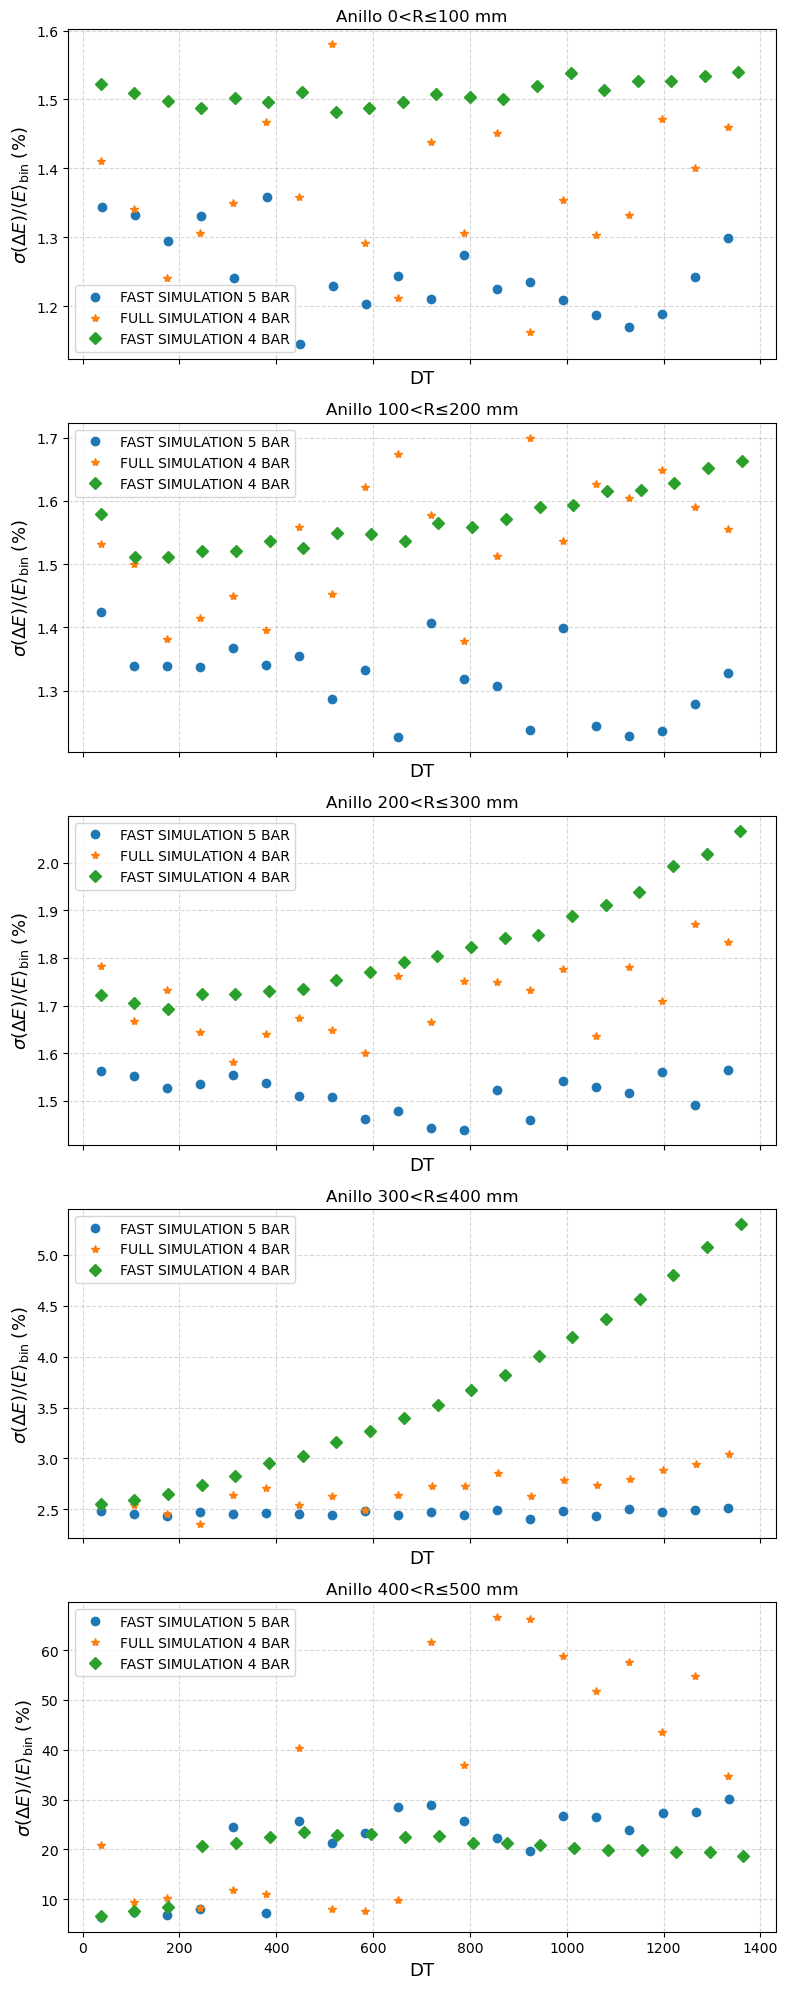

In [236]:
simulaciones = [sim1, sim2, sim3]
marcadores   = ['o', '*', 'D']
anillos      = [(0,100),(100,200),(200,300),(300,400),(400,500)]
n_anillos    = len(anillos)

# Creamos una figura con n_anillos subplots en columna, compartiendo el eje x
fig, axs = plt.subplots(n_anillos, 1, figsize=(8, 4*n_anillos), sharex=True)

for j, (r_min, r_max) in enumerate(anillos):
    ax = axs[j]
    for sim, titulo, marcador in zip(simulaciones, titulos, marcadores):
        # Máscara de anillo
        mask = (sim['R'] > r_min) & (sim['R'] <= r_max)
        DT   = sim.loc[mask, 'DT'].values
        E_c  = Ec_all[titulos.index(titulo)][j]
        if len(E_c) != len(DT):
            E_c = E_c[mask.values]

        # Bins y centros en DT
        bins       = np.linspace(DT.min(), DT.max(), 21)
        dt_centers = 0.5 * (bins[:-1] + bins[1:])

        sig_pct = []
        for k in range(len(bins)-1):
            bmask = (DT >= bins[k]) & (DT < bins[k+1])
            if np.sum(bmask) < 10:
                sig_pct.append(np.nan)
                continue

            deltaE = E_c[bmask] - np.mean(E_c[bmask])
            counts, edges = np.histogram(deltaE, bins=40)
            centers = 0.5 * (edges[:-1] + edges[1:])
            try:
                p0    = [counts.max(), 0, np.std(deltaE)]
                popt  = curve_fit(gaussiana, centers, counts, p0=p0)[0]
                sigma = popt[2]
            except RuntimeError:
                sigma = np.nan

            # σ relativo en % respecto a ⟨E⟩ del bin
            sig_pct.append((sigma / np.mean(E_c[bmask])) * 100)

        ax.plot(dt_centers, sig_pct,
                marker=marcador, linestyle='None',
                label=titulo)

    ax.set_ylabel(r'$\sigma(\Delta E)/\langle E\rangle_{\rm bin}\;(\%)$')
    ax.set_title(f'Anillo {r_min}<R≤{r_max} mm')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='best')
    ax.set_xlabel('DT')

plt.tight_layout()

In [237]:
for j, (r_min, r_max) in enumerate(anillos):
    # Crear figura única por anillo
    fig, ax = plt.subplots(figsize=(8,5))

    for sim, titulo, marcador in zip(simulaciones, titulos, marcadores):
        # Máscara de anillo
        mask = (sim['R'] > r_min) & (sim['R'] <= r_max)
        DT   = sim.loc[mask, 'DT'].values
        E_c  = Ec_all[titulos.index(titulo)][j]
        if len(E_c) != len(DT):
            E_c = E_c[mask.values]

        # Definir bins y centros
        bins       = np.linspace(DT.min(), DT.max(), 21)
        dt_centers = 0.5 * (bins[:-1] + bins[1:])

        sig_pct = []
        for k in range(len(bins)-1):
            bmask = (DT >= bins[k]) & (DT < bins[k+1])
            if np.sum(bmask) < 10:
                sig_pct.append(np.nan)
                continue

            deltaE = E_c[bmask] - np.mean(E_c[bmask])
            counts, edges = np.histogram(deltaE, bins=40)
            centers = 0.5 * (edges[:-1] + edges[1:])
            try:
                p0    = [counts.max(), 0, np.std(deltaE)]
                popt  = curve_fit(gaussiana, centers, counts, p0=p0)[0]
                sigma = popt[2]
            except RuntimeError:
                sigma = np.nan

            sig_pct.append((sigma / np.mean(E_c[bmask])) * 100)

        # Plot por simulación
        ax.plot(dt_centers, sig_pct,
                marker=marcador, linestyle='None',
                label=titulo)

    # Formato
    ax.set_xlabel('DT')
    ax.set_ylabel(r'$\sigma(\Delta E)/\langle E\rangle_{\rm bin}\;(\%)$')
    ax.set_title(f'Anillo {r_min}<R≤{r_max} mm')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='best')
    plt.tight_layout()

    # Guardar la figura de este anillo
    fname = f'graficas/desviaciones/sigma_Ec_anillo_{r_min}_{r_max}.png'
    fig.savefig(fname, dpi=300)
    plt.close(fig)
    print(f'Figura guardada: {fname}')

Figura guardada: graficas/desviaciones/sigma_Ec_anillo_0_100.png
Figura guardada: graficas/desviaciones/sigma_Ec_anillo_100_200.png
Figura guardada: graficas/desviaciones/sigma_Ec_anillo_200_300.png
Figura guardada: graficas/desviaciones/sigma_Ec_anillo_300_400.png
Figura guardada: graficas/desviaciones/sigma_Ec_anillo_400_500.png


# TOY EXPERIMENT

Para comprobar la fiabilidad de los ajustes previos realizamos el toy experiment

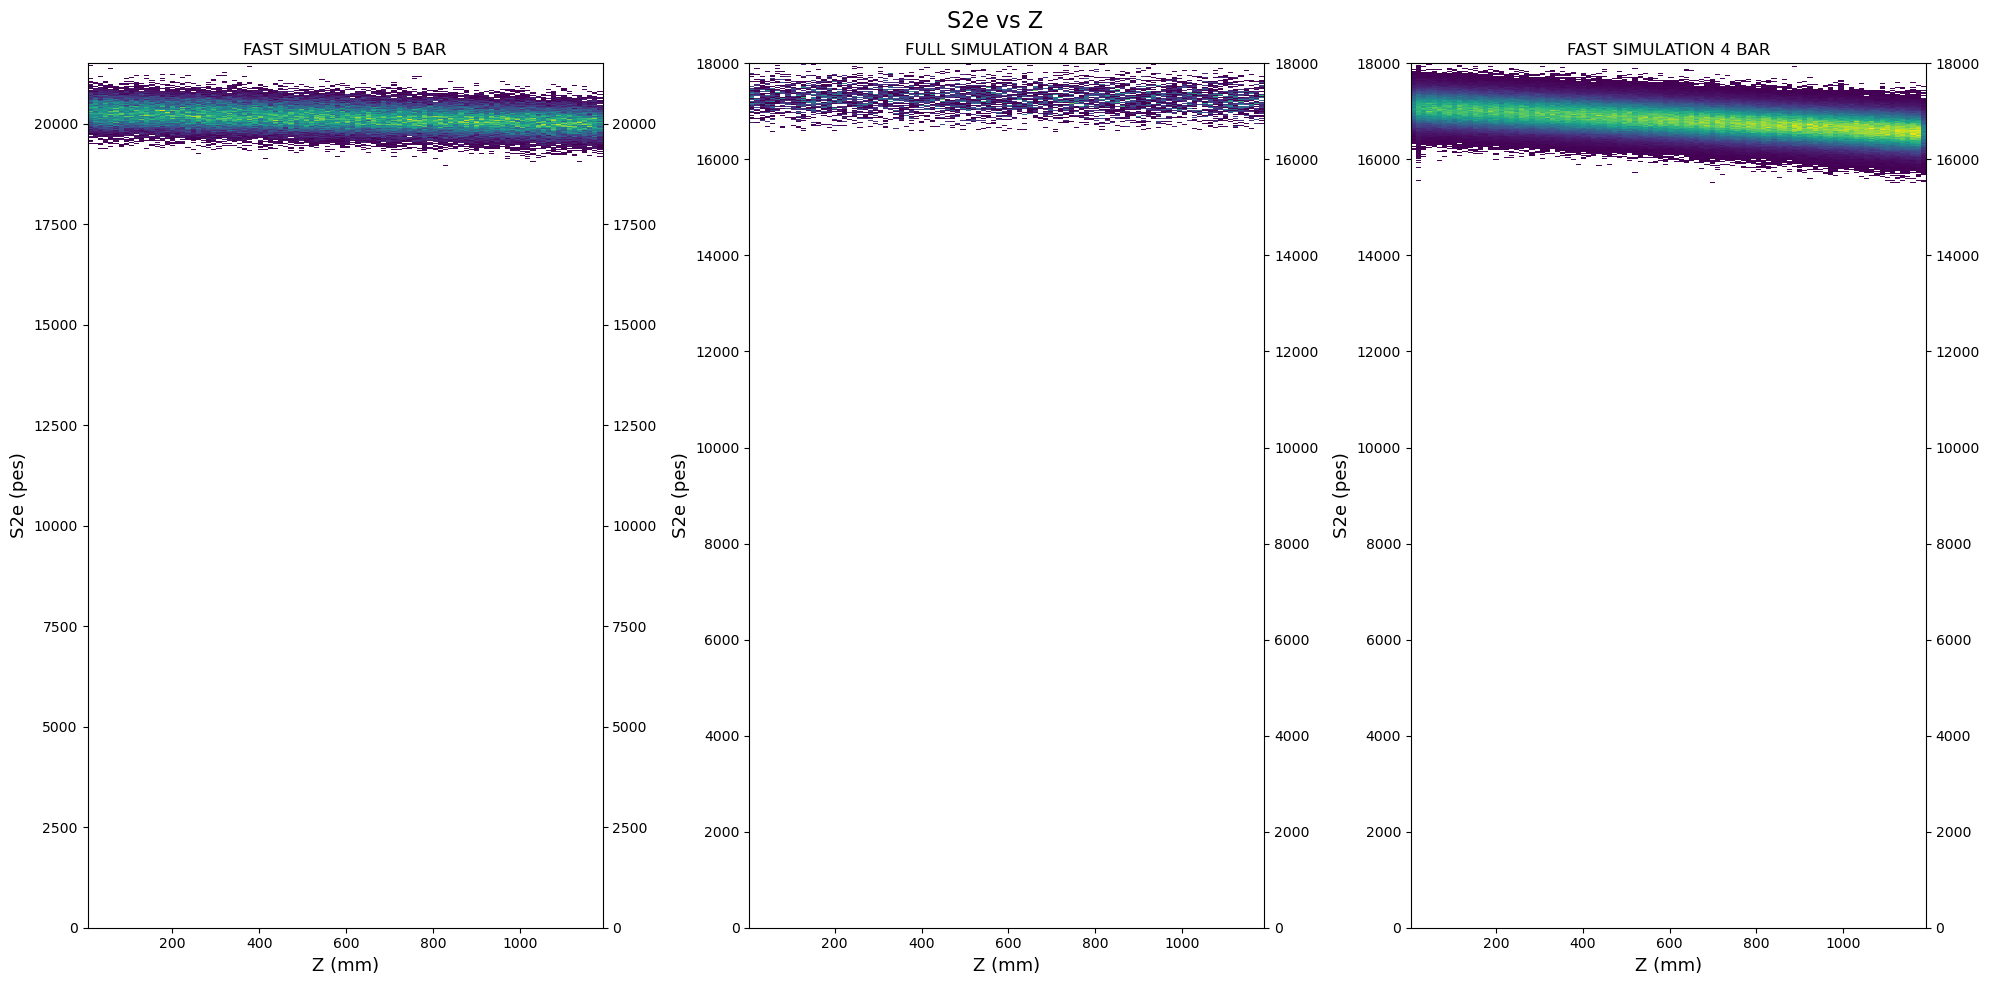

In [240]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
sim1_profile300 = sim1[(sim1.R > 0) & (sim1.R <= 200)  & (sim1.S2e > 18000)]
sim2_profile300 = sim2[(sim2.R > 0) & (sim2.R <= 200)  & (sim2.S2e > 16500)]
sim3_profile300 = sim3[(sim3.R > 0) & (sim3.R <= 200)  & (sim3.S2e > 15500)]

# sim1_profile300 = sim1[(sim1.R > 0) & (sim1.R <= 250) ]
# sim2_profile300 = sim2[(sim2.R > 0) & (sim2.R <= 250) ]
# sim3_profile300 = sim3[(sim3.R > 0) & (sim3.R <= 250) ]

# Datos y configuraciones
datos = [
    (sim1_profile300['Z'], sim1_profile300['S2e'], (0, 21500)),
    (sim2_profile300['Z'], sim2_profile300['S2e'], (0, 18000)),
    (sim3_profile300['Z'], sim3_profile300['S2e'], (0, 18000))
]

# Graficar en bucle
for i, ax in enumerate(axes):
    Z, S2e, ylim = datos[i]
    h = ax.hist2d(Z, S2e, bins=[100, 200], cmin=1)
    ax.set_xlabel('Z (mm)')
    ax.set_ylabel('S2e (pes)')
    ax.set_title(titulos[i])
    ax.set_ylim(*ylim)

    # Duplicar ticks y etiquetas del eje Y a la derecha
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', labelright=True)

    # Colorbar asociado
    # cbar = plt.colorbar(h[3], ax=ax)
    # cbar.set_label('Número de eventos')

# Título general y diseño
fig.suptitle('S2e vs Z', fontsize=16)
plt.tight_layout()

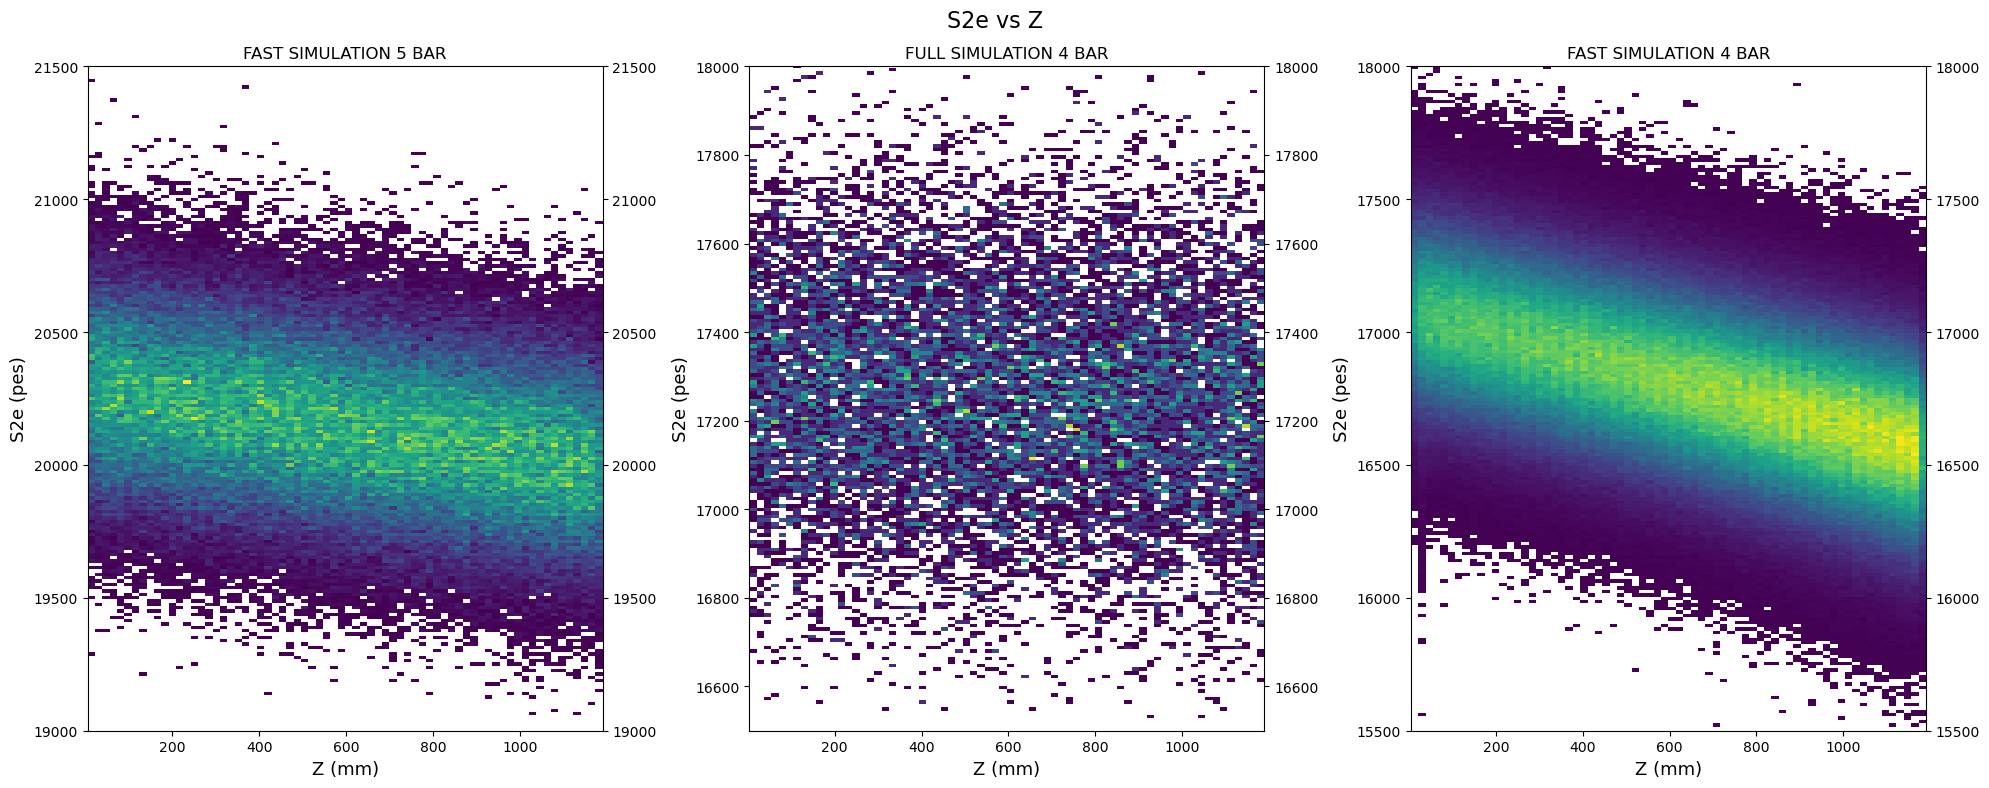

In [241]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

datos = [
    (sim1_profile300['Z'], sim1_profile300['S2e'], (19000, 21500)),
    (sim2_profile300['Z'], sim2_profile300['S2e'], (16500, 18000)),
    (sim3_profile300['Z'], sim3_profile300['S2e'], (15500, 18000))]
# Graficar en bucle
for i, ax in enumerate(axes):
    Z, S2e, ylim = datos[i]
    h = ax.hist2d(Z, S2e, bins=[70, 200], cmin=1)
    ax.set_xlabel('Z (mm)')
    ax.set_ylabel('S2e (pes)')
    ax.set_title(titulos[i])
    ax.set_ylim(*ylim)

    # Duplicar ticks y etiquetas del eje Y a la derecha
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', labelright=True)

    # Colorbar asociado
    # cbar = plt.colorbar(h[3], ax=ax)
    # cbar.set_label('Número de eventos')

# Título general y diseño
fig.suptitle('S2e vs Z', fontsize=16)
plt.tight_layout()
plt.savefig("graficas/S2e zoom")

In [242]:
def plot_profile_2(Z, S2e):
    num_bins = 20
    bins = np.linspace(Z.min(), Z.max(), num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    mean_S2e, std_S2e = [], []

    for i in range(num_bins):
        mask = (Z >= bins[i]) & (Z < bins[i + 1])
        S2e_in_bin = S2e[mask]
        
        if len(S2e_in_bin) > 0:
            mean_S2e.append(np.mean(S2e_in_bin))
            std_S2e.append(np.std(S2e_in_bin) / np.sqrt(len(S2e_in_bin)))
        else:
            mean_S2e.append(np.nan)
            std_S2e.append(np.nan)

    bin_centers = np.array(bin_centers)
    mean_S2e = np.array(mean_S2e)
    std_S2e = np.array(std_S2e)
    valid_mask = ~np.isnan(mean_S2e)

    # Ajuste exponencial
    popt, pcov = curve_fit(
        modelo_exp,
        bin_centers[valid_mask],
        mean_S2e[valid_mask],
        sigma=std_S2e[valid_mask],
        absolute_sigma=True,
        p0=[np.max(mean_S2e[valid_mask]), (Z.max() - Z.min()) / 2],
        bounds=([0, 1e-3], [np.inf, np.inf])
    )

    E0, tau = popt
    fit_line = modelo_exp(bin_centers, *popt)

    return bin_centers, mean_S2e, std_S2e, fit_line, E0, tau, pcov

Simulación 1:
    E_0  = 20290.49 ± 1.30 (pes)
    tau = 95245.44 ± 735.83 (μs)

Simulación 2:
    E_0  = 17289.27 ± 3.99 (pes)
    tau = 386256.77 ± 43165.87 (μs)

Simulación 3:
    E_0  = 17085.52 ± 0.35 (pes)
    tau = 43816.83 ± 49.02 (μs)



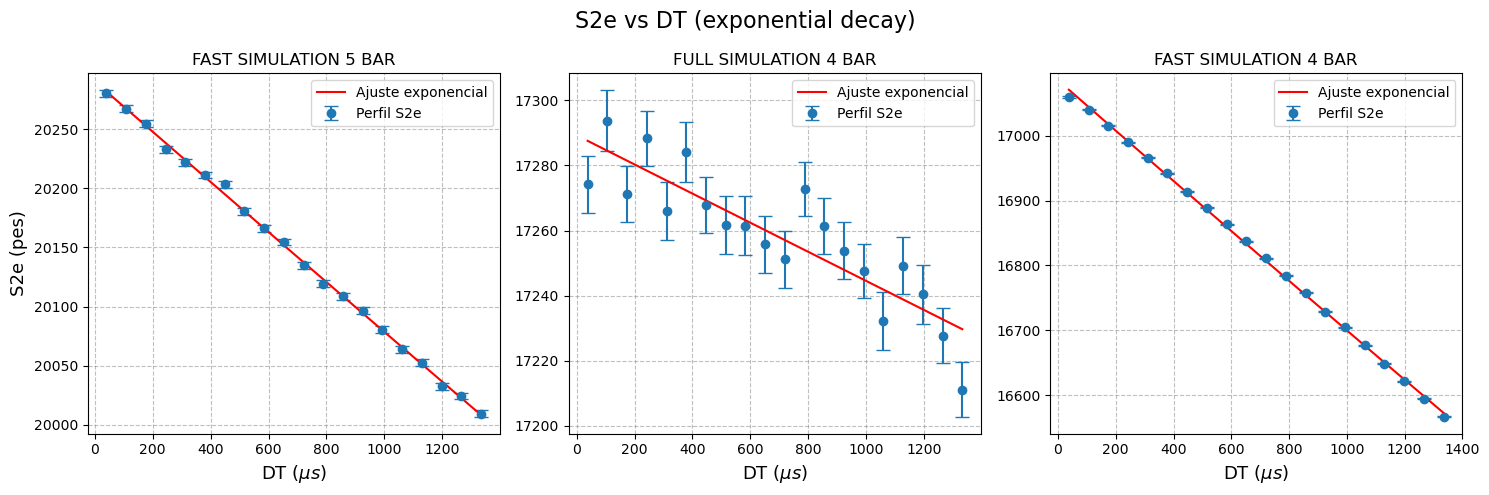

In [243]:
# Crear subfiguras
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Datos y títulos
datos = [sim1_profile300, sim2_profile300, sim3_profile300]

# Inicializar listas para guardar resultados
taus = []
s_taus = []
E0s = []
s_E0s = []

# Bucle sobre los tres conjuntos de datos
for i in range(3):
    sim = datos[i]
    ax = axes[i]
    
    # Perfil y ajuste exponencial
    bin_centers, mean_S2e, std_S2e, fit_line, E0, tau, pcov = plot_profile_2(sim['DT'], sim['S2e'])
    s_tau = np.sqrt(pcov[1, 1])
    s_E0 = np.sqrt(pcov[0, 0])
    
    # Guardar resultados
    E0s.append(E0)
    s_E0s.append(s_E0)
    taus.append(tau)
    s_taus.append(s_tau)

    # --- Imprimir resultados con decimales ---
    print(f"Simulación {i+1}:")
    print(f"    E_0  = {E0:.2f} ± {s_E0:.2f} (pes)")
    print(f"    tau = {tau:.2f} ± {s_tau:.2f} (μs)")
    print()

    # Graficar sin E_0 ni tau en la leyenda
    ax.errorbar(bin_centers, mean_S2e, yerr=std_S2e, fmt='o', capsize=5, label="Perfil S2e")
    ax.plot(bin_centers, fit_line, 'r-', label="Ajuste exponencial")
    ax.set_title(titulos[i])
    ax.set_xlabel('DT ($\\mu s$)')
    if i == 0:
        ax.set_ylabel('S2e (pes)')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.5)

# Espaciado
fig.suptitle('S2e vs DT (exponential decay)', fontsize=16)
plt.tight_layout()
plt.savefig("graficas/S2e_profile.png")

100%|██████████| 10000/10000 [00:06<00:00, 1515.17it/s]


E0 medio: 17085.51 ± 2.21
tau medio: 43840.71 ± 868.82
E_{0} = 17087.6
$\tau_{0} = 42619.53 \pm 825.08$
E_{1} = 17079.1
$\tau_{1} = 46073.01 \pm 938.11$
E_{2} = 17087.8
$\tau_{2} = 43132.09 \pm 818.12$


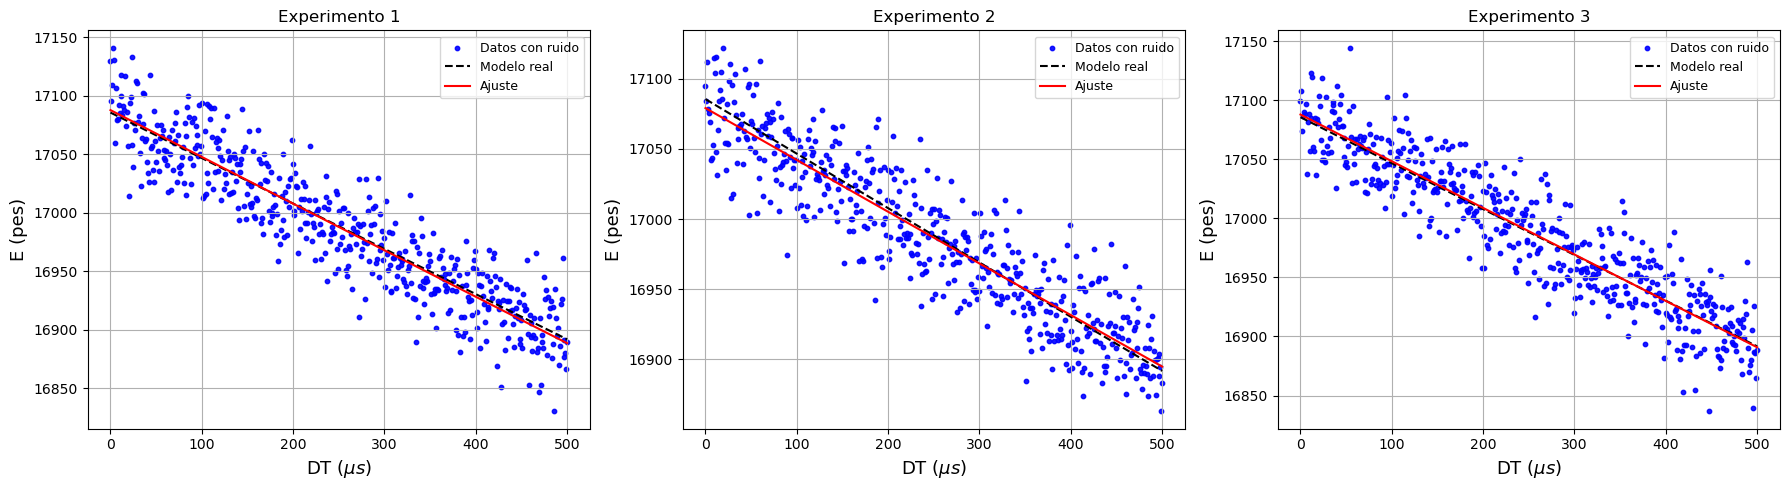

In [244]:
# Generar datos sintéticos
x_datos = np.linspace(0, 500, 500)
E0_verdadero = E0
tau_verdadero = tau
y_ideal = modelo_exp(x_datos, E0_verdadero, tau_verdadero)
size = 10000
ruido_sigma = 25

# Arreglos para guardar resultados
E0s = np.zeros(size)
taus = np.zeros(size)
s_taus = np.zeros(size)

# Guardar 3 curvas ejemplo
ejemplos_x = []
ejemplos_y = []
ejemplos_ajuste = []

np.random.seed(0)
for i in tqdm(range(size)):
    ruido = np.random.normal(0, ruido_sigma, size=x_datos.size)
    y_obs = y_ideal + ruido
    try:
        popt, pcov = curve_fit(modelo_exp, x_datos, y_obs, p0=[90, 4])
        E0s[i], taus[i] = popt
        s_taus[i] = np.sqrt(np.abs(pcov[1, 1]))  # puede que la cov. sea negativa por inestabilidad numérica
        if i < 3:
            ejemplos_x.append(x_datos.copy())
            ejemplos_y.append(y_obs.copy())
            ejemplos_ajuste.append(modelo_exp(x_datos, *popt))
    except RuntimeError:
        E0s[i], taus[i], s_taus[i] = np.nan, np.nan, np.nan


# Filtramos resultados válidos
E0s = E0s[~np.isnan(E0s)]
taus = taus[~np.isnan(taus)]

# Estadísticas
print(f"E0 medio: {np.mean(E0s):.2f} ± {np.std(E0s):.2f}")
print(f"tau medio: {np.mean(taus):.2f} ± {np.std(taus):.2f}")

# Graficar 3 casos individuales
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i in range(3):
    axs[i].scatter(ejemplos_x[i], ejemplos_y[i], label='Datos con ruido', color='blue', s=10, alpha=0.9)
    axs[i].plot(x_datos, y_ideal, '--', label='Modelo real', color='black')
    axs[i].plot(x_datos, ejemplos_ajuste[i], label='Ajuste', color='red')
    axs[i].set_title(f'Experimento {i+1}')
    axs[i].set_xlabel('DT ($\\mu s$)')
    axs[i].set_ylabel('E (pes)')
    axs[i].legend(loc='best', fontsize=9)
    axs[i].grid(True)
    print(f"E_{{{i}}} = {E0s[i]:.1f}")
    print(f"$\\tau_{{{i}}} = {taus[i]:.2f} \\pm {s_taus[i]:.2f}$")

plt.tight_layout()
plt.savefig("graficas/toy experiment")

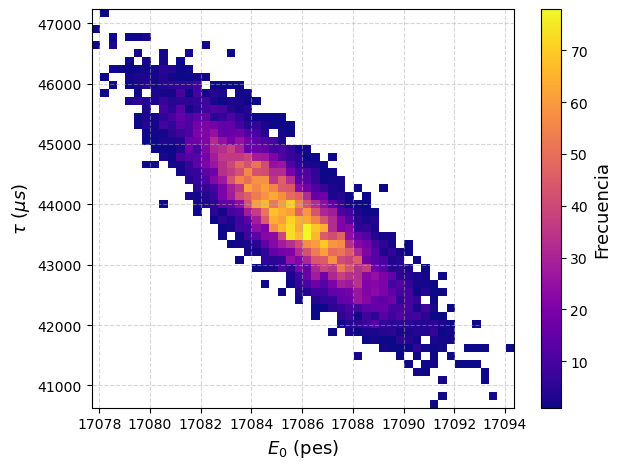

In [245]:
plt.hist2d(E0s, taus, bins=50, cmap='plasma', cmin=1)
plt.xlabel('$E_0$ (pes)')
plt.ylabel(r'$\tau \ (\mu s)$')
plt.colorbar(label='Frecuencia')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("graficas/correlacion tau E0")

Media de pulls: -0.011489
Desviación estándar de pulls: 0.995459


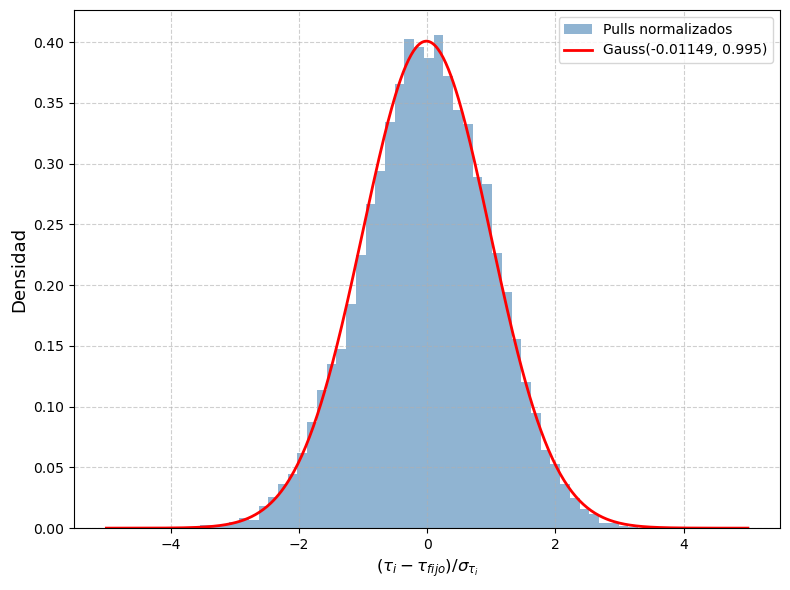

In [246]:
# --- Valor fijo ---
tau_fijo = tau

# --- Pulls normalizados ---
z = (taus - tau_fijo) / s_taus

# --- Media y desviación de los pulls ---
mu_z = np.mean(z)
sigma_z = np.std(z)
print(f"Media de pulls: {mu_z:.6f}")
print(f"Desviación estándar de pulls: {sigma_z:.6f}")

# --- Histograma ---
fig, ax = plt.subplots(figsize=(8, 6))
counts, bins, _ = ax.hist(z, bins=50, density=True, alpha=0.6, color='steelblue', label='Pulls normalizados')

# --- Gaussiana empírica ---
x_vals = np.linspace(-5, 5, 500)
gauss_fit = norm.pdf(x_vals, loc=mu_z, scale=sigma_z)
ax.plot(x_vals, gauss_fit, 'r-', lw=2, label=fr'Gauss({mu_z:.5f}, {sigma_z:.3f})')

# --- Etiquetas y estilo ---
ax.set_xlabel('$(\\tau_i - \\tau_{fijo})/\\sigma_{\\tau_i}$', fontsize=12)
ax.set_ylabel('Densidad')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.savefig("graficas/pull")